# 1주차 업데이트 현황

1. 위도 경도 데이터를 활용한 위치 정보 4분할 (2020-03-16[월])
2. input column을 target column의 시간 간격대 통일 (2020-03-18[수])
3. GridSearchCV를 통한 하이퍼 파라미터 튜닝

# Colab 사용을 위한 세션 연결 코드

In [3]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

E: Package 'python-software-properties' has no installation candidate


KeyboardInterrupt: ignored

In [1]:
!mkdir -p drive
!google-drive-ocamlfuse drive

fuse: mountpoint is not empty
fuse: if you are sure this is safe, use the 'nonempty' mount option


In [2]:
# 코랩환경에서 작업여부를 나타내는 변수
IS_COLAB = True 

if IS_COLAB:
  path = "drive/colab/dacon_jeju_traffic/data/"
else:
  path = "I don't know yet"

print(f"path of data files is {path}")

path of data files is drive/colab/dacon_jeju_traffic/data/


# 대회 설명

## 1. 배경

  제주도내 주민등록인구는 2019년 11월 기준 69만명으로, 연평균 4%대로 성장했습니다.

  외국인과 관광객까지 고려하면 전체 상주인구는 90만명을 넘을 것으로 추정됩니다. 

  제주도민 증가와 외국인의 증가로 현재 제주도의 교통체증이 심각한 문제로 떠오르고 있습니다. 

  2017년 한국은행 제주본부에 따르면 제주도 일부 지역은 교통체증이 서울보다 심각합니다.

  따라서, 제주테크노파크는 교통난 심화를 해결하기 위해 데이터 분석 대회를 개최합니다.

  제주도 버스의 효율적인 운행를 위해 퇴근시간 승차인원을 예측하는 모델을 만들어 주세요!

## 2. 채점방식
 
 <a href="https://ko.wikipedia.org/wiki/%ED%8F%89%EA%B7%A0_%EC%A0%9C%EA%B3%B1%EA%B7%BC_%ED%8E%B8%EC%B0%A8 
">RMSE(Root Mean Square Error) </a>
  <img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/af4b2b4b785c08cab0bfdbb1eb4e3ab878753b04" alt = "akinator" height="100" width="400" />
  <img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/423025a8622ab59a1abc95ecbd2f83bbf4f13a5c
" alt = "akinator" height="100" width="600" />

## 3. 데이터

 **(train, test , bus_bts 공통 사항)**

    해당 데이터에는 버스카드를 통해 결제를 한 경우에 대한 정류소 승, 하차 데이터로 모든 승차정보의 경우는 기록이 되어있지만, 

    버스에서 하차를 할 때, 버스카드를 찍지 않는 경우, 해당 기록이 비어 있는 상태입니다. 따라서, 승차 인원수와 하차 인원수가 동일하지 않고 다소 차이가 있음을 미리 알려드립니다.

 **(train, test csv 공통사항)**

    해당 버스정류장에 대한 각각의 위도, 경도가 제공이 되어있는 상태로 같은 정류장 이름이지만 위도와 경도가 서로 다른 경우가 존재합니다. 

    해당 경우는, 같은 정류장 이름을 가지고 있는 길 건너편의 정류장에 해당이 됩니다.

  **1. train.csv and test.csv**

    train.csv 의 경우, 2019년 9월 제주도의 각 날짜, 출근시간(6시~12시)의 버스 정류장별 승하차 인원, 퇴근시간(18시~20시)의 버스 정류장별 승차 인원이 기록되어 있습니다.

    test.csv의 경우, 2019년 10월의 각 날짜, 출근시간(오전 6시~12시)의 버스 정류장별 승하차 인원이 기록되어 있습니다.

  **2. bus_bts.csv**

    bus_bts의 경우, 버스카드별로  사이인 경우만 있습니다.

  **3.     submission_제출양식.csv** 

    submission_제출양식의 경우, test data의 ID와 목표변수인 18시~20시 승차 인원로만 이루어져 있습니다.

    참가자분들께서는 test.csv에서 ID와 예측값을 결합하여, 해당 submission_제출양식.csv 파일형식 처럼 만든 이후,

    해당 제출 파일 양식 그대로(변수명 포함된 상태) 제출을 해주시면 됩니다

 **4. 추가 사용 가능 데이터**

    a) (8회 kcb 시각화 대회의 제주도 금융라이프 데이터(jeju_financial_life_data.csv)

    b) 행정동별 위도 경도 데이터 https://dacon.io/?module=file&act=procFileDownload&file_srl=244977&sid=8cd192144ab18be0e02e4a16f851729b&module_srl=228539  (H - 행정동, B - 법정동)

## 4. 분류 vs 회귀

  **1. 분류**

    분류는 예측하고자 하는 종속변수(y)의 값이 클래스(레이블)로 주어지는 경우를 말합니다. 
    e.g) 타이타닉호 탑승자의 생존여부 예측, 천체 유형 분류 대회
    하지만 위의 두 가지의 예시는 이진 분류(Binary Classification)와 다중 분류(Multiple Classification)로 나눌 수 있습니다. 
    이를 해석하면 이진 분류는 단순히 "이다" or "아니다" 를 분류하는 것이며, 다중 분류는 주어진 여러개의 클래스 중에서 하나를 분류해내는 것입니다.

    분류를 위한 평가지표는
    1. Accuracy
    2. F1 Score
    3. ROC_AUC Curve
    4. Gini Coefficient

  **2. 회귀**

    회귀는 예측하고자 하는 종속변수(y)의 값이 수치형 데이터인 경우를 말합니다.
    e.g) 제주 퇴근시간 버스승차인원 예측, 펀다  상점 매출 예측 대회.
    회귀의 예를 보면 분류 문제의 예시와는 달리 특정 수치를 예측하는 것으로 알 수 있습니다.

    회귀 문제를 위한 평가지표에는
    1. MSE(Mean Sqaured Error)
    2. RMSE(Root Mean Sqaured Error)
    3. RMSLE(Root Mean Sqaured Logarithmic Error)

    회귀문제를 처리하는 평가지표에는 많은 공통점이 있습니다. 그것은 바로 실제 값과 예측값의 차이를 활용한다는 것입니다. 
    그런데 그 "차이"만 활용하면 음수 값도 발생할 수 있고 이는 양수 값과 같이 활용되었을때 차이에 대한 의미가 희석되기 때문에 이를 제곱(Sqaure)하고 얻은 값들을 평균(Mean) 한 것이 MSE입니다.
    RMSE는 이 결과 MSE에 Root를 씌운 지표이고, RMSLE는 머신러닝/딥러닝 모델을 통해 얻은 예측값과 기존의 실제 값을 상용로그 값을 씌운 후 이후 과정을 RMSE하는 과정을 말합니다. 
    상용로그를 씌우는 이유는 우리가 예측해야 하는 값의 수치형 데이터의 데이터 범위가 넓을 때 더 좋은 예측을 위해 scaling한 후 RMSE하는 것입니다.


 


### **(별첨) 측정지표 생성**

제주 퇴근시간 버스승차인원 예측 대회에서 사용할 평가지표는 위에서 언급한 평가 지표 중 RMSE(Root Mean Squared Error)입니다. 그러나 우리는 파이썬에서 sklean 패키지를 활용하여 깊은 노력 없이 만들 수 있겠지만, 직접 만들어보는 시간을 가져보겠습니다.


In [0]:
# y_true and y_pred is pd.Series datatype
def custoum_rmse(y_true,y_pred):
  # pandas.Series 데이터 길이 일치 확인
  assert len(y_true) == len(y_pred)

  diff_btw_true_pred = (y_true - y_pred)
  diff_sqaured_btw_true_pred = dff_btw_true_pred.apply(lambda x:x**2)
  mean_diff_squared_btw_true_pred = np.mean(diff_sqaured_btw_true_pred)
  root_mean_diff_squared_btw_true_pred = mean_diff_squared_btw_true_pred**0.5

  RMSE_result = root_mean_diff_squared_btw_true_pred

  return RMSE_result

# 데이터 Import 및 데이터 셋 형태 및 데이터 타입 확인

## 필요 패키지 Import

In [0]:
# 주요 패키지 import

import os 
import warnings
import pandas as pd
import numpy as np
import re

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import plotly.offline as py
import plotly.graph_objs as go
import plotly.express as px

import folium # 지도 관련 시각화
from folium.plugins import MarkerCluster #지도 관련 시각화
import geopy.distance #거리 계산해주는 패키지 사용

from sklearn.preprocessing import OneHotEncoder

import datetime

# 경고메시지 제거
warnings.filterwarnings(action='ignore')

In [5]:
print(f"path of data files is {path}")

path of data files is drive/colab/dacon_jeju_traffic/data/


프로젝트에서 지정한 데이터 파일에 저장되어있는 파일 목록 확인

In [6]:
ls -l drive/colab/dacon_jeju_traffic/data

total 375930
-r--r--r-- 1 root root 289504974 Nov  7 06:53  bus_bts.csv
-rw-r--r-- 1 root root   2310165 May 11  2019  jeju_financial_life_data.csv
-rw-r--r-- 1 root root   4103729 Mar  8 12:17 'submission_데이콘 서포터즈 1기_권영인.csv'
-r--r--r-- 1 root root   2281715 Nov  7 06:39  submission_sample.csv
-r--r--r-- 1 root root  29758470 Nov  7 06:40  test.csv
-r--r--r-- 1 root root  55756093 Nov  7 06:40  train.csv
-r--r--r-- 1 root root   1234237 Dec 21 07:47 '행정_법정동 중심좌표.xlsx'


## 필요 데이터 Import

In [0]:
df_train = pd.read_csv(path+"train.csv")
df_test = pd.read_csv(path+"test.csv")
df_bus_bts =  pd.read_csv(path+"bus_bts.csv")
df_jeju_finance = pd.read_csv(path+"jeju_financial_life_data.csv")
df_bjd_location = pd.read_excel(path+"행정_법정동 중심좌표.xlsx")

### Train dataset과 Test dataset

In [8]:
print(f"shape of train dataset is {df_train.shape}")
print(f"shape of train dataset is {df_test.shape}")

shape of train dataset is (415423, 21)
shape of train dataset is (228170, 20)


In [9]:
df_train.head()

,id,date,bus_route_id,in_out,station_code,station_name,latitude,longitude,6~7_ride,7~8_ride,8~9_ride,9~10_ride,10~11_ride,11~12_ride,6~7_takeoff,7~8_takeoff,8~9_takeoff,9~10_takeoff,10~11_takeoff,11~12_takeoff,18~20_ride
0,0,2019-09-01,4270000,시외,344,제주썬호텔,33.48990,126.49373,0.0,1.0,2.0,5.0,2.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,2019-09-01,4270000,시외,357,한라병원,33.48944,126.48508,1.0,4.0,4.0,2.0,5.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0
2,2,2019-09-01,4270000,시외,432,정존마을,33.48181,126.47352,1.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
3,3,2019-09-01,4270000,시내,1579,제주국제공항(600번),33.50577,126.49252,0.0,17.0,6.0,26.0,14.0,16.0,0.0,0.0,0.0,0.0,0.0,0.0,53.0
4,4,2019-09-01,4270000,시내,1646,중문관광단지입구,33.25579,126.41260,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [10]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 415423 entries, 0 to 415422
Data columns (total 21 columns):
id               415423 non-null int64
date             415423 non-null object
bus_route_id     415423 non-null int64
in_out           415423 non-null object
station_code     415423 non-null int64
station_name     415423 non-null object
latitude         415423 non-null float64
longitude        415423 non-null float64
6~7_ride         415423 non-null float64
7~8_ride         415423 non-null float64
8~9_ride         415423 non-null float64
9~10_ride        415423 non-null float64
10~11_ride       415423 non-null float64
11~12_ride       415423 non-null float64
6~7_takeoff      415423 non-null float64
7~8_takeoff      415423 non-null float64
8~9_takeoff      415423 non-null float64
9~10_takeoff     415423 non-null float64
10~11_takeoff    415423 non-null float64
11~12_takeoff    415423 non-null float64
18~20_ride       415423 non-null float64
dtypes: float64(15), int64(3), object

In [11]:
df_test.head()

,id,date,bus_route_id,in_out,station_code,station_name,latitude,longitude,6~7_ride,7~8_ride,8~9_ride,9~10_ride,10~11_ride,11~12_ride,6~7_takeoff,7~8_takeoff,8~9_takeoff,9~10_takeoff,10~11_takeoff,11~12_takeoff
0,415423,2019-10-01,4270000,시외,344,제주썬호텔,33.48990,126.49373,4.0,4.0,7.0,2.0,9.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1,415424,2019-10-01,4270000,시외,357,한라병원,33.48944,126.48508,1.0,6.0,6.0,1.0,8.0,11.0,0.0,0.0,0.0,0.0,0.0,0.0
2,415425,2019-10-01,4270000,시외,432,정존마을,33.48181,126.47352,2.0,4.0,2.0,2.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,415426,2019-10-01,4270000,시내,1579,제주국제공항(600번),33.50577,126.49252,1.0,11.0,18.0,8.0,26.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0
4,415427,2019-10-01,4270000,시내,1636,롯데호텔,33.24872,126.41032,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [12]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 228170 entries, 0 to 228169
Data columns (total 20 columns):
id               228170 non-null int64
date             228170 non-null object
bus_route_id     228170 non-null int64
in_out           228170 non-null object
station_code     228170 non-null int64
station_name     228170 non-null object
latitude         228170 non-null float64
longitude        228170 non-null float64
6~7_ride         228170 non-null float64
7~8_ride         228170 non-null float64
8~9_ride         228170 non-null float64
9~10_ride        228170 non-null float64
10~11_ride       228170 non-null float64
11~12_ride       228170 non-null float64
6~7_takeoff      228170 non-null float64
7~8_takeoff      228170 non-null float64
8~9_takeoff      228170 non-null float64
9~10_takeoff     228170 non-null float64
10~11_takeoff    228170 non-null float64
11~12_takeoff    228170 non-null float64
dtypes: float64(14), int64(3), object(3)
memory usage: 34.8+ MB


#### 컬럼 해석

##### 1. id <br/>
  : 해당 데이터에서의 고유한 ID(train, test와의 중복은 없음)
##### 2. date <br/>
  : 날짜
##### 3. bus_route_id <br/>
  : 노선 ID
##### 4. in_out <br/>
  : 시내, 시외버스 구분
##### 5. station_code
  : 해당 승하차 정류소의 ID
##### 6. station_name
  : 해당 승하차 정류소의 이름
##### 7. latitude
  : 해당 버스 정류장의 위도  (같은 정류장 이름이어도 버스의 진행 방향에 따라 다를 수 있음)
##### 8. longitude
  : 해당 버스 정류장의 경도  (같은 정류장 이름이어도 버스의 진행 방향에 따라 다를 수 있음)
##### 9. x~x ride
  : X:00:00부터 X:59:59까지 승차한 인원 수
##### 10. x~x takeoff
  : X:00:00부터 X:59:59까지 하차한 인원 수
##### 11. 18~20 ride
  : 18:00:00부터 19:59:59까지 승차한 인원 수  (train data에만 존재)

train dataset과 test dataset을 비교해 보았을 때, 지도 학습을 통해 얻어내야할 데이터는 train dataset의 18~20ride 컬럼이다.

In [0]:
target = df_train["18~20_ride"]

그렇다면, 대회에서 말했듯이, train과 test는 각각 9월과 10월의 데이터를 하루도 빠지지 않고 가지고 있을까?


In [0]:
day_num_sep = 30
day_num_oct = 31

assert len(df_train.date.value_counts().index) == day_num_sep
#assert len(df_test.date.value_counts().index) == day_num_oct # Error

위의 코드에서 assert len(df_test.date.value_counts().index) == day_num_oct 는 Error가 나는데, 그 이유는 test 데이터는 10월 1일부터 16일의 데이터만을 가지기 때문이다.

In [15]:
day_num_of_train = list(df_train.date.value_counts().sort_index().index.map(lambda x: x.split("-")[2]))
print(f"num_of_day in train set: {day_num_of_train}")

day_num_of_test = list(df_test.date.value_counts().sort_index().index.map(lambda x: x.split("-")[2]))
print(f"num_of_day in test set: {day_num_of_test}")

num_of_day in train set: ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30']
num_of_day in test set: ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16']


In [0]:
df_train_date_count = df_train.groupby("date")["id"].count().to_frame().reset_index()
df_train_date_count["date"] = df_train.groupby("date")["id"].count().to_frame().reset_index().date.apply(lambda x: x.split("-")[2])
df_train_date_count.columns = ["date","count"]
df_train_date_count["month"] = "Sep"


df_test_date_count = df_test.groupby("date")["id"].count().to_frame().reset_index()
df_test_date_count["date"] = df_test.groupby("date")["id"].count().to_frame().reset_index().date.apply(lambda x: x.split("-")[2])
df_test_date_count.columns = ["date","count"]
df_test_date_count["month"] = "Oct"
df_test_date_count

dummy = pd.concat([df_train_date_count,df_test_date_count],axis=0)
df_date_month_count = dummy.groupby(["date","month"])["count"].max().reset_index()

# plt.figure(figsize=[8,4])

# sns.lineplot(data=df_date_month_count,x="date",y="count",hue="month")

In [17]:
fig = go.Figure()

trace_sep = go.Scatter(x=df_date_month_count.loc[df_date_month_count.month=="Sep"].date,y=df_date_month_count.loc[df_date_month_count.month=="Sep"]["count"],name="Sep")
trace_oct = go.Scatter(x=df_date_month_count.loc[df_date_month_count.month=="Oct"].date,y=df_date_month_count.loc[df_date_month_count.month=="Oct"]["count"],name="Oct")

fig.add_trace(trace_sep)
fig.add_trace(trace_oct)

fig.update_layout(title={"text":"daily passenger count by month",
                                    "xanchor":"center",
                                    "yanchor":"top",
                                    'y':0.9,
                                    'x':0.5,
                                    "font":{"size":30}},
                            xaxis_title="day of month",
                            yaxis_title="count",
                            width=1000,
                            height=600)

fig.show()

위에서 언급한 생각을 시각화해보면, train dataset인 9월(Sep)은 30일까지 존재하고, test dataset인 10월(Oct)은 16일까지 존재함을 알 수 있다. 그리고 train과 test간의 일자별 데이터의 양의 차이는 적은 것으로 보여진다. 

### 버스카드별 승하차 정보(bus_bts)

In [18]:
print(f"the shape of df_bus_bts: {df_bus_bts.shape}")

the shape of df_bus_bts: (2409414, 13)


In [19]:
df_bus_bts.head()

,user_card_id,bus_route_id,vhc_id,geton_date,geton_time,geton_station_code,geton_station_name,getoff_date,getoff_time,getoff_station_code,getoff_station_name,user_category,user_count
0,1.010010e+15,23000000,149793674,2019-09-10,06:34:45,360,노형오거리,2019-09-10,07:10:31,592.0,화북초등학교,1,1
1,1.010010e+15,23000000,149793674,2019-09-10,06:34:58,360,노형오거리,2019-09-10,06:56:27,3273.0,고산동산(광양방면),1,1
2,1.019160e+15,21420000,149793535,2019-09-10,07:19:07,2495,동광환승정류장4(제주방면),2019-09-10,07:40:29,431.0,정존마을,4,1
3,1.019150e+15,21420000,149793512,2019-09-09,09:14:47,3282,대정환승정류장(대정읍사무소),2019-09-09,10:02:46,431.0,정존마을,1,1
4,1.010010e+15,21420000,149793512,2019-09-09,09:28:53,2820,삼정지에듀,2019-09-09,10:21:37,2972.0,제주국제공항(종점),4,1


In [20]:
df_bus_bts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2409414 entries, 0 to 2409413
Data columns (total 13 columns):
user_card_id           float64
bus_route_id           int64
vhc_id                 int64
geton_date             object
geton_time             object
geton_station_code     int64
geton_station_name     object
getoff_date            object
getoff_time            object
getoff_station_code    float64
getoff_station_name    object
user_category          int64
user_count             int64
dtypes: float64(2), int64(5), object(6)
memory usage: 239.0+ MB


#### 컬럼해석

1. user_card_id

  : 해당 승객의 버스카드ID
2. bus_route_id

  : 노선ID
3. vhc_id

  : 차량ID
4. geton_date

  : 해당 승객이 탑승한 날짜
5. geton_time

  : 해당 승객이 탑승한 시간
6. geton_station_code

  : 승차정류소의 ID
7. geton_station_name

  : 승차정류소의 이름
8. getoff_date

  : 해당 승객이 하차한 날짜 (하차태그 없는 경우, NaN)
9. getoff_time

  : 해당 승객이 하차한 시간 (하차태그 없는 경우, NaN)
10. getoff_station_code

  : 하차정류소의 ID (하차태그 없는 경우, NaN)
11. getoff_station_name

  : 하차정류소의 이름 (하차태그 없는 경우, NaN)
12. user_category

  : 승객 구분 (01-일반, 02-어린이, 04-청소년, 06-경로, 27-장애 일반, 28-장애 동반, 29-유공 일반, 30-유공 동반)
13. user_count

  :  해당 버스카드로 계산한 인원수  ( ex- 3은 3명 분의 버스비를 해당 카드 하나로 계산한 것)

### 제주도 금융라이프 데이터

In [21]:
print(f"the shape of jeju financial dataset: {df_jeju_finance.shape}")

the shape of jeju financial dataset: (10422, 27)


In [22]:
df_jeju_finance.head()

,zip_cd,year_month,x_axis,y_axis,sex,age,job_majorc,job_smallc,job_public,job_profession,job_self,job_none,job_other,avg_income,med_income,avg_spend,avg_foreign_spend,avg_debt,avg_debt_credit,avg_debt_noneb,avg_debt_mortgage,avg_debt_deposit,avg_debt_collateral,avg_credit_rat,medium_resid_rat,large_resid_rat,vehicle_own_rat
0,63299,201902,126.565889,33.513210,1,54,0.0,0.166667,0.000000,0.000000,0.166667,0.500000,0.166667,37188000,33000000,2611619,0,24285196,11419148,8863595,55550000,0,55550000,5,-999999.0,-999999.0,0.000000
1,63560,201902,126.497121,33.247225,1,59,0.0,0.125000,0.000000,0.000000,0.375000,0.500000,0.000000,35378000,32000000,1987726,0,108571077,25896955,13317443,0,200000000,74421721,4,-999999.0,-999999.0,0.000000
2,63560,201902,126.497121,33.247225,2,49,0.0,0.250000,0.000000,0.000000,0.125000,0.625000,0.000000,32119000,34000000,3529667,172405,26424335,12015311,12015311,40833359,0,40833359,2,-999999.0,-999999.0,0.000000
3,63560,201902,126.497121,33.247225,1,54,0.0,0.181818,0.090909,0.090909,0.363636,0.272727,0.000000,64746000,68200000,4868477,12046,647716901,39952556,21558153,36697792,0,706300496,4,-999999.0,-999999.0,0.166667
4,63560,201902,126.497121,33.247225,1,49,0.0,0.250000,0.000000,0.000000,0.250000,0.500000,0.000000,29578000,29700000,5209689,0,248232725,35712501,5568751,0,0,626810674,5,-999999.0,-999999.0,0.000000


In [23]:
df_jeju_finance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10422 entries, 0 to 10421
Data columns (total 27 columns):
zip_cd                 10422 non-null int64
year_month             10422 non-null int64
x_axis                 10422 non-null float64
y_axis                 10422 non-null float64
sex                    10422 non-null int64
age                    10422 non-null int64
job_majorc             10422 non-null float64
job_smallc             10422 non-null float64
job_public             10422 non-null float64
job_profession         10422 non-null float64
job_self               10422 non-null float64
job_none               10422 non-null float64
job_other              10422 non-null float64
avg_income             10422 non-null int64
med_income             10422 non-null int64
avg_spend              10422 non-null int64
avg_foreign_spend      10422 non-null int64
avg_debt               10422 non-null int64
avg_debt_credit        10422 non-null int64
avg_debt_noneb         10422 non-null

#### 컬럼 의미 해석

##### 1. KEY Dimmension	
1. zip_cd	신우편번호	신우편번호	 	지역: 제주특별자치도
2. year_month	기준월	해당 정보 자료의 시점기준 정보	 	 
3. x_axis	좌표	해당 우편번호의 경도	 	 
4. y_axis	좌표	해당 우편번호의 위도	 	 
5. sex	성별	1: 남성, 2: 여성	 	 
6. age	연령대	5세 구간(24: 24세이하, 29: 25-29세, 34: 30-34세, …. , 74: 70-74세, 79: 75-79세, 99: 80세이상)	 	 

##### 2. 직업관련
1. job_majorc	직업군별 비율-대기업	고객군의 직업군별 비율 : 대기업	ratio	범위 : 0~1
2. job_smallc	직업군별 비율-중소기업	고객군의 직업군별 비율 : 중소기업	ratio	범위 : 0~1
3. job_public	직업군별 비율-공기업	고객군의 직업군별 비율 : 공기업	ratio	범위 : 0~1
4. job_profession	직업군별 비율-전문직	고객군의 직업군별 비율 : 전문직	ratio	범위 : 0~1
5. job_self	직업군별 비율-자영업	고객군의 직업군별 비율 : 자영업	ratio	범위 : 0~1
6. job_none	직업군별 비율-무직	고객군의 직업군별 비율 : 무직	ratio	범위 : 0~1
7. job_other	직업분별 비율-기타	고객군의 직업군별 비율 : 판단불가	ratio	범위 : 0~1

##### 3. 소득관련
1. avg_income	평균연소득	고객군별 평균 KCB 결정연소득	numeric	단위 : 원
2. med_income	중위연소득	고객군별 KCB 결정연소득의 중위수(median)값	numeric	단위 : 원

##### 4. 소비관련
1. avg_spend	평균소비액	고객군별 3개월 평균 KCB 총카드이용금액	numeric	단위 : 원
2. avg_foreign_spend	평균해외소비액	고객군별 3개월 평균 KCB 총 카드해외이용금액	numeric	단위 : 원

##### 5. 부채관련
1. avg_debt	채무 평균보유액	고객군별 채무보유자의 평균 KCB 총대출잔액	numeric	단위 : 원
2. avg_debt_credit	채무 평균보유액-신용대출	고객군별 채무보유자의 평균 KCB 신용대출잔액	numeric	단위 : 원
4. avg_debt_noneb	채무 평균보유액-비은행대출	고객군별 채무보유자의 평균 KCB 비은행권대출잔액	numeric	단위 : 원
5. avg_debt_mortgage	채무 평균보유액-주택담보대출	고객군별 채무보유자의 평균 KCB 주택담보대출잔액	numeric	단위 : 원
6. avg_debt_deposit	채무 평균보유액-예적금유가증권담보대출	고객군별 채무보유자의 평균 KCB 예적금 또는 유가증권 담보대출 잔액	numeric	단위 : 원
7. avg_debt_collateral	채무 평균보유액-물건담보대출	고객군별 채무보유자의 평균 KCB 물건담보(주거용 및 비주거용 부동산, 자동차 등) 대출 잔액	numeric	단위 : 원

##### 6. 신용도판단정보	
1. avg_credit_rat	평균관리지수	고객군별 신용평균	numeric	 

##### 7. 부동산관련
1. medium_resid_rat	중대형이상 거주비율	고객군의 중대형 평형 거주비율(30평 이상) (-999,999: 부동산가격이 없는경우)	ratio	범위 : 0~1
2. large_resid_rat	대형 거주비율	고객군의 대형 평형 거주비율(40평 이상) (-999,999: 부동산가격이 없는경우)	ratio	범위 : 0~1
3. vehicle_own_rat	중대형 차량소유비율	고객군별 중대형 차량소유비율	ratio	범위 : 0~1

### 행정 법정동 중심좌표

In [24]:
print(f"the shape of df_bjd_location: {df_bjd_location.shape}")

the shape of df_bjd_location: (22219, 8)


In [25]:
df_bjd_location.head()

,코드,시도,시군구,읍면동,하위,위도,경도,코드종류
0,1111051500,서울특별시,종로구,청운효자동,NaN,37.584009,126.970626,H
1,1111053000,서울특별시,종로구,사직동,NaN,37.575408,126.965944,H
2,1111054000,서울특별시,종로구,삼청동,NaN,37.590758,126.980996,H
3,1111055000,서울특별시,종로구,부암동,NaN,37.594768,126.965574,H
4,1111056000,서울특별시,종로구,평창동,NaN,37.613029,126.974485,H


In [26]:
df_bjd_location.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22219 entries, 0 to 22218
Data columns (total 8 columns):
코드      22219 non-null int64
시도      22219 non-null object
시군구     22080 non-null object
읍면동     22219 non-null object
하위      15052 non-null object
위도      22219 non-null float64
경도      22219 non-null float64
코드종류    22219 non-null object
dtypes: float64(2), int64(1), object(5)
memory usage: 1.4+ MB


#### <a href="https://eastsky3483.tistory.com/159">행정동과 법정동은 무엇일까요??</a>

##### **1. 법정동**

법정동이란 법(法)으로 정(定)한동(洞)이라는 뜻으로 법률로 지정된 행정구역 단위입니다. 법정동은 대부분 1914년 시행된 행정구역 통폐합을 통해 정해진 것으로, 예전부터 전해저온 고유 지명을 그 명칭으로 하며 거의 변동이 없습니다. 현재는 정부기관의 공부, 토지의 구획, 지적도, 부동산의 등기, 재산권 행위 등에서 일반적으로 사용되고 있는 주소지라 할 수 있습니다. 법정동은 실제 내가 거주하고 있는 동이라 보시면 되며, 주소지또한 법정동으로 기재하게 됩니다.

##### **2. 행정동**

행정동이란, 행정편의를 위하여 설정한 행정구역으로 행정능률과 주민편의를 도모하기 위해 설정된 행정구역의 단위입니다. 행정동은 대부분 주민 수의 증감에 따라 수시로 설치되거나 폐지되는 만큼 여건에 따라 쉽게 변할 수 있습니다. 모든 행정동에는 동주민센터가 있으며, 공부(公簿)의 보관과 민원발급, 주민관리 등 행정 처리를 관할하게 됩니다. 



행정 법정동 데이터는 데이터 자체가 제주시만을 위한 것이 아니기 때문에 제주시만을 위한 데이터로 추려낼 필요가 있어보입니다.

# 탐색적 데이터 분석 (EDA, Exploratory Data Analysis)

해당 절에서는 우리가 가져온 세가지 데이터(퇴근시간 버스승차인원 데이터, 제주도 금융라이프 데이터 그리고 행정 법정동 데이터)의 컬럼들에 담긴 의미를 이해하고 어떤 방식으로 정제하고 가공해야할 지 인사이트를 얻어내려고 합니다.

## 1. 퇴근시간 버스 승차인원 데이터

In [27]:
train_column_list = list(df_train.columns)
for idx,value in enumerate(train_column_list):
  if idx+1 == 1:
    order_lang = "st"
  elif idx+1 == 2:
    order_lang="nd"
  elif idx+1 == 3:
    order_lang="rd"
  else:
    order_lang="th"  
  print(f"{idx+1}{order_lang} column: {value}")

1st column: id
2nd column: date
3rd column: bus_route_id
4th column: in_out
5th column: station_code
6th column: station_name
7th column: latitude
8th column: longitude
9th column: 6~7_ride
10th column: 7~8_ride
11th column: 8~9_ride
12th column: 9~10_ride
13th column: 10~11_ride
14th column: 11~12_ride
15th column: 6~7_takeoff
16th column: 7~8_takeoff
17th column: 8~9_takeoff
18th column: 9~10_takeoff
19th column: 10~11_takeoff
20th column: 11~12_takeoff
21th column: 18~20_ride


### 2. date

date 컬럼은 데이터셋 형태 및 데이터타입 확인 절에서 간단하게 살펴보았지만, 위에서 사용했던 시각화 자료를 다시 읽어보겠습니다.

In [0]:
df_train_date_count = df_train.groupby("date")["id"].count().to_frame().reset_index()
df_train_date_count["date"] = df_train.groupby("date")["id"].count().to_frame().reset_index().date.apply(lambda x: x.split("-")[2])
df_train_date_count.columns = ["date","count"]
df_train_date_count["month"] = "Sep"


df_test_date_count = df_test.groupby("date")["id"].count().to_frame().reset_index()
df_test_date_count["date"] = df_test.groupby("date")["id"].count().to_frame().reset_index().date.apply(lambda x: x.split("-")[2])
df_test_date_count.columns = ["date","count"]
df_test_date_count["month"] = "Oct"
df_test_date_count

dummy = pd.concat([df_train_date_count,df_test_date_count],axis=0)
df_date_month_count = dummy.groupby(["date","month"])["count"].max().reset_index()

Text(0.5, 1, 'daily passenger count by month')

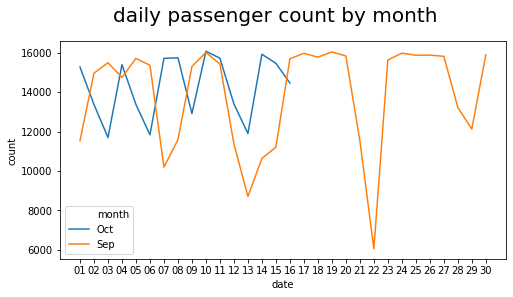

In [29]:
plt.figure(figsize=[8,4])

sns.lineplot(data=df_date_month_count,x="date",y="count",hue="month")

plt.suptitle("daily passenger count by month",y=1,fontsize=20)

In [30]:
fig = go.Figure()

trace_sep = go.Scatter(x=df_date_month_count.loc[df_date_month_count.month=="Sep"].date,y=df_date_month_count.loc[df_date_month_count.month=="Sep"]["count"],name="Sep")
trace_oct = go.Scatter(x=df_date_month_count.loc[df_date_month_count.month=="Oct"].date,y=df_date_month_count.loc[df_date_month_count.month=="Oct"]["count"],name="Oct")

fig.add_trace(trace_sep)
fig.add_trace(trace_oct)

fig.update_layout(title={"text":"daily passenger count by month",
                                    "xanchor":"center",
                                    "yanchor":"top",
                                    'y':0.9,
                                    'x':0.5,
                                    "font":{"size":30}},
                            xaxis_title="day of month",
                            yaxis_title="count",
                            width=1000,
                            height=600)

fig.show()

해당 그래프를 통해, 훈련셋이던 테스트셋이던 어느 특정 일시에 count 수가 크게는 4000건 줄어듦을 확인할 수 있습니다. 제 생각에는 "주말"에는 출퇴근하는 사람 수가 적기 때문임을 생각해볼 수 있습니다. 그렇다면 확인해도록 하겠습니다.

In [0]:
day_type_dict = {0:"weekday",1:"weekday",2:"weekday",3:"weekday",4:"weekday",5:"weekend",6:"weekend"}
day_name_dict = {0:"Mon",1:"Tue",2:"Wed",3:"Thr",4:"Fri",5:"Sat",6:"Sun"}


df_train_date = df_train.date.value_counts().to_frame().sort_index().reset_index()
df_train_date.columns = ["date","count"]
df_train_date["month"] = "Sep"
df_train_date["day"] = df_train_date.date.apply(lambda x: x.split("-")[2])


df_test_date = df_test.date.value_counts().to_frame().sort_index().reset_index()
df_test_date.columns = ["date","count"]
df_test_date["month"] = "Oct"
df_test_date["day"] = df_test_date.date.apply(lambda x: x.split("-")[2])

df_train_test_date = pd.concat([df_train_date,df_test_date],axis=0)
df_train_test_date["day_name"] = df_train_test_date.date.apply(lambda x: day_name_dict[datetime.datetime.strptime(x,"%Y-%m-%d").weekday()])
df_train_test_date["day_type"] = df_train_test_date.date.apply(lambda x: day_type_dict[datetime.datetime.strptime(x,"%Y-%m-%d").weekday()])

In [32]:
df_train_test_date_agg = df_train_test_date.groupby(["month","day_type"])["count"].agg(["max","min","mean"]).sort_index(ascending=False)
df_train_test_date_agg = df_train_test_date_agg.reset_index()
df_train_test_date_agg

,month,day_type,max,min,mean
0,Sep,weekend,13219,6053,10899.222222
1,Sep,weekday,16030,8708,15110.952381
2,Oct,weekend,13395,11836,12625.250000
3,Oct,weekday,16066,11695,14805.750000


Text(0.5, 1.12, 'agg values of dayname per month')

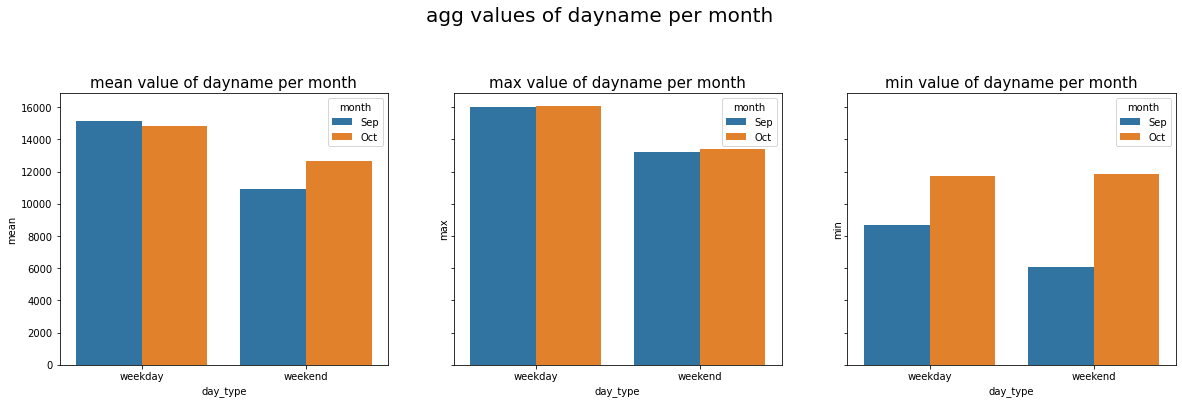

In [33]:
fig, axes = plt.subplots(1,3,figsize=[20,5],sharey=True)
agg_list = ["mean","max","min"]

for idx,ax in enumerate(axes):
  sns.barplot(x="day_type",y=agg_list[idx],hue="month",ax=ax,data=df_train_test_date_agg,order=["weekday","weekend"])
  ax.set_title(f"{agg_list[idx]} value of dayname per month",fontsize=15)

plt.suptitle("agg values of dayname per month",fontsize=20,y=1.12)

In [34]:
df_train_test_date_agg_melt = pd.melt(frame=df_train_test_date_agg,id_vars=["month","day_type"],var_name="aggfunc type",value_name="# of people")

fig = px.bar(data_frame=df_train_test_date_agg_melt,x="day_type",y="# of people",facet_col="aggfunc type",color="month",barmode="group",category_orders={"aggfunc type":["mean","max","min"]})

fig.update_layout(title={"text":"agg values of dayname per month",
                                    "xanchor":"center",
                                    "yanchor":"top",
                                    'y':0.98,
                                    'x':0.5,
                                    "font":{"size":20}},
                            xaxis={"autorange":"reversed"},
                            yaxis_title="count",
                            width=1200,
                            height=400)

fig.show()

평균 값으로 봤을때, 평일이 주말보다 탑승인원이 많은 것을 알 수 있다. 그런데 10월의 평일, 주말 최소값과 비교했을 때, 9월의 평일과 주말의 최소값은 9월의 각각 평균값과 비교해 보았을 떄 많게는 절반이상 차이남을 알 수 있다. 왜일까?

내가 생각한 답변은 **추석연휴와 같은 공휴일이 끼어있기 때문일 것이다.** 왜냐하면 추석 연휴에 출퇴근하는 사람이 얼마나 있으랴!

In [35]:
df_train_test_date

,date,count,month,day,day_name,day_type
0,2019-09-01,11538,Sep,01,Sun,weekend
1,2019-09-02,14960,Sep,02,Mon,weekday
2,2019-09-03,15485,Sep,03,Tue,weekday
3,2019-09-04,14739,Sep,04,Wed,weekday
4,2019-09-05,15706,Sep,05,Thr,weekday
5,2019-09-06,15352,Sep,06,Fri,weekday
6,2019-09-07,10198,Sep,07,Sat,weekend
7,2019-09-08,11582,Sep,08,Sun,weekend
8,2019-09-09,15297,Sep,09,Mon,weekday
9,2019-09-10,16005,Sep,10,Tue,weekday


In [0]:
sep_mins_list = df_train_test_date[df_train_test_date["month"] == "Sep"].groupby("day_type")["count"].min().values

sep_weekday_min = sep_mins_list[0]
sep_weekend_min = sep_mins_list[1]

In [37]:
df_train_test_date.loc[df_train_test_date["count"] == sep_weekday_min]

,date,count,month,day,day_name,day_type
12,2019-09-13,8708,Sep,13,Fri,weekday


2019년 9월 달력을 한번 살펴보자

<img src="http://blogfiles.naver.net/MjAxOTA4MDRfMjM0/MDAxNTY0ODg0MDUzMDI2.x2ieAErU3yyUSjNpyv5WHArBRXxnbrRkHCsRuL8Yg-Ig.KVrM3LtkP0tpGp9WOeRDn3XS5fJhWqgcpJzqWE2BJAQg.JPEG.modernrocker/2019%B3%E2_9%BF%F9%B4%DE%B7%C2_C.jpg" width=600 height=400 />

2019년 9월 13일은 추석당일로써 공휴일인데 내 생각대로 가장 낮은 날을 기록했다. 그렇다면, 우리의 데이터에 **평일인 공휴일도 나타낼 수 있도록** 해야겠다.

2019년 10월의 달력은 아래와 같다.


<img src="http://blogfiles.naver.net/MjAxOTA5MDhfMjQw/MDAxNTY3OTI3ODE4OTEw.zby6mUfZ5b8sn_jgSLJpy7GPo-8kBIztAKZuJBhbC5gg.CpehvbP3EuhcytW3CM3bjvOBH-H5sHsmB5Feo68-ZHEg.JPEG.modernrocker/2019%B3%E2_10%BF%F9%B4%DE%B7%C2_C.jpg" width=600 height=400 />

따라서 개천절과 한글날인 3일과 9일 모두 포함될 수 있도록 하자.


In [0]:
hoillday_date_list = ["2019-09-12","2019-09-13","2019-09-14","2019-10-03","2019-10-09"]

def filter_hoilday(strdate,list):

  if strdate in list:
    return True
  else:
    return False

In [0]:
df_train_test_date["is_holiday"] =df_train_test_date.date.map(lambda x: filter_hoilday(x,hoillday_date_list))

### 3. bus_route_id

In [40]:
num_distinct_bus_route = len(df_train.bus_route_id.value_counts().index)
print(f"The distinct number of bus route is {num_distinct_bus_route}")

The distinct number of bus route is 613


버스 경로의 유일한 값의 개수는 613개이다. 그리고 이 컬럼은 다른 데이터셋인 버스 카드 데이터셋(bus_bts.csv) 와 bus_route_id로 조인할 수 있는 컬럼이다.

### 4. in_out

In [41]:
bus_in_out_index_list = list(df_train.in_out.value_counts().index)
print(f"The kinds of bus in jeju are {bus_in_out_index_list}, the number of null value is {df_train.in_out.isnull().sum()}, the number of 시내 buses is {(df_train.in_out == '시내').sum()}, the number of 시외 buses is {(df_train.in_out == '시외').sum()}")

The kinds of bus in jeju are ['시내', '시외'], the number of null value is 0, the number of 시내 buses is 408500, the number of 시외 buses is 6923


### 5.station_code

In [42]:
bus_station_code_index_list = list(df_train.station_code.value_counts().index)
print(f"The number of bus station in jeju are {len(bus_station_code_index_list)}, the number of null value is {df_train.station_code.isnull().sum()}")

The number of bus station in jeju are 3563, the number of null value is 0


### 6.station_name

In [43]:
bus_station_name_index_list = list(df_train.station_name.value_counts().index)
print(f"The number of bus station in jeju are {len(bus_station_name_index_list)}, the number of null value is {df_train.station_name.isnull().sum()}")

The number of bus station in jeju are 1961, the number of null value is 0


정류장의 유일한 수인 station code는 3653개인데 반해서 정류장 이름 station_name은 절반 정도 수준에 미친다. 그말은 즉슨, 서귀포 행과 제주시 행과 같은 방향 정보는 정류장 이름에 포함되어 있지 않은 것 같다.

### 7. Latitude(위도) & Longitude(경도) - from baseline beginner and intermediate code

해당 컬럼은 1차 제출 때는 고려하지 않았던 부분이다. 제주도는 크게 북쪽과 남쪽 즉, 제주시와 서귀포시에 많이 몰려서 거주하는 경향이 있으며, baseline code는 제주도 지역을 크게 4 방위로 나누어 이를 카테고리형 자료로 나타내려고 한다.

In [44]:
# 해당 주요 장소의 임의 지역 위도, 경도

jeju=(33.51411, 126.52969) # 제주 측정소 근처
gosan=(33.29382, 126.16283) #고산 측정소 근처
seongsan=(33.38677, 126.8802) #성산 측정소 근처
po=(33.24616, 126.5653) #서귀포 측정소 근처

#제주도 지역이 보일 수 있는 위치의 위도, 경도를 표시한 뒤, folium.Map에 변수로 넣고, map_osm에 할당
map_osm= folium.Map((33.399835, 126.506031),zoom_start=9)
mc = MarkerCluster()

mc.add_child( folium.Marker(location=jeju,popup='제주 측정소',icon=folium.Icon(color='red',icon='info-sign') ) ) #제주 측정소 마커 생성
map_osm.add_child(mc) #마커를 map_osm에 추가

mc.add_child( folium.Marker(location=gosan,popup='고산 측정소',icon=folium.Icon(color='red',icon='info-sign') ) )
map_osm.add_child(mc) 

mc.add_child( folium.Marker(location=seongsan,popup='성산 측정소',icon=folium.Icon(color='red',icon='info-sign') ) )
map_osm.add_child(mc) 

mc.add_child( folium.Marker(location=po,popup='서귀포 측정소',icon=folium.Icon(color='red',icon='info-sign') ) )
map_osm.add_child(mc)

### 7. input column을 target column의 시간 간격대 통일 - from baseline code

In [45]:
df_train.head()

,id,date,bus_route_id,in_out,station_code,station_name,latitude,longitude,6~7_ride,7~8_ride,8~9_ride,9~10_ride,10~11_ride,11~12_ride,6~7_takeoff,7~8_takeoff,8~9_takeoff,9~10_takeoff,10~11_takeoff,11~12_takeoff,18~20_ride
0,0,2019-09-01,4270000,시외,344,제주썬호텔,33.48990,126.49373,0.0,1.0,2.0,5.0,2.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,2019-09-01,4270000,시외,357,한라병원,33.48944,126.48508,1.0,4.0,4.0,2.0,5.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0
2,2,2019-09-01,4270000,시외,432,정존마을,33.48181,126.47352,1.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
3,3,2019-09-01,4270000,시내,1579,제주국제공항(600번),33.50577,126.49252,0.0,17.0,6.0,26.0,14.0,16.0,0.0,0.0,0.0,0.0,0.0,0.0,53.0
4,4,2019-09-01,4270000,시내,1646,중문관광단지입구,33.25579,126.41260,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


베이스라인 코드에서 언급하는 것처럼, 예측하려는 target code는 18~20 두 시간 간격대 인데 반해 투입하는 ride와 takeoff 시간 간격대는 1시간 대이다. 그러므로 이를 동일하게 통일시켜보자.

### 8. 추가적인 생각

In [46]:
df_train.head()

,id,date,bus_route_id,in_out,station_code,station_name,latitude,longitude,6~7_ride,7~8_ride,8~9_ride,9~10_ride,10~11_ride,11~12_ride,6~7_takeoff,7~8_takeoff,8~9_takeoff,9~10_takeoff,10~11_takeoff,11~12_takeoff,18~20_ride
0,0,2019-09-01,4270000,시외,344,제주썬호텔,33.48990,126.49373,0.0,1.0,2.0,5.0,2.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,2019-09-01,4270000,시외,357,한라병원,33.48944,126.48508,1.0,4.0,4.0,2.0,5.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0
2,2,2019-09-01,4270000,시외,432,정존마을,33.48181,126.47352,1.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
3,3,2019-09-01,4270000,시내,1579,제주국제공항(600번),33.50577,126.49252,0.0,17.0,6.0,26.0,14.0,16.0,0.0,0.0,0.0,0.0,0.0,0.0,53.0
4,4,2019-09-01,4270000,시내,1646,중문관광단지입구,33.25579,126.41260,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


분명.. 같은 버스 루트인데도 시외와 시내가 다르다??? 그말은 in_out은 해당 버스의 노선이 시내 버스인지 시외 버스인지가 아니다라는 것을 뜻하는 것 같다. 한 번 확인해 보도록 하자.

In [47]:
df_train.loc[df_train.bus_route_id == 4270000].in_out.value_counts()

시외    423
시내    353
Name: in_out, dtype: int64

그렇다면, station_code에 따라서 시내와 시외가 나뉘는 것이 아닐까?? head를 통해 가장 먼저 조회할 수 있는 특정 bus_route_id인 '4270000'을 활용하여 살펴보자

In [0]:
df_train_one = df_train.loc[df_train.bus_route_id == 4270000]

is_in_out_equal = (df_train_one.groupby("station_code")["in_out"].max() == df_train_one.groupby("station_code")["in_out"].min()).sum()
num_df_train_one = len(df_train_one.groupby("station_code")["in_out"])

assert is_in_out_equal == num_df_train_one

assert 문에 에러가 나지 않는걸로 보아.. in_out은 station이 시내에 있는지 시외에 있는지를 의미하는 듯하다. 이를 전체로 확장하여 확인해보자.

In [0]:
df_train_bus_route_id = df_train.groupby(["bus_route_id","station_code","in_out"]).count().reset_index().loc[:,["bus_route_id","station_code","in_out"]]
num_station_code_equal = (df_train_bus_route_id.groupby("station_code")["in_out"].max() == df_train_bus_route_id.groupby("station_code")["in_out"].min()).sum()
num_station_code = len(df_train_bus_route_id.groupby("station_code")["in_out"])

assert num_station_code == num_station_code_equal

전체로 보니 맞는다는 것을 확인할 수 있었다. in_out은 해당 정류장(station_code)이 시내에 있는지 시외에 있는지를 의미한다.

## 2. 버스카드 별 승하차 정보(bus_bts)

In [50]:
df_bus_bts.head()

,user_card_id,bus_route_id,vhc_id,geton_date,geton_time,geton_station_code,geton_station_name,getoff_date,getoff_time,getoff_station_code,getoff_station_name,user_category,user_count
0,1.010010e+15,23000000,149793674,2019-09-10,06:34:45,360,노형오거리,2019-09-10,07:10:31,592.0,화북초등학교,1,1
1,1.010010e+15,23000000,149793674,2019-09-10,06:34:58,360,노형오거리,2019-09-10,06:56:27,3273.0,고산동산(광양방면),1,1
2,1.019160e+15,21420000,149793535,2019-09-10,07:19:07,2495,동광환승정류장4(제주방면),2019-09-10,07:40:29,431.0,정존마을,4,1
3,1.019150e+15,21420000,149793512,2019-09-09,09:14:47,3282,대정환승정류장(대정읍사무소),2019-09-09,10:02:46,431.0,정존마을,1,1
4,1.010010e+15,21420000,149793512,2019-09-09,09:28:53,2820,삼정지에듀,2019-09-09,10:21:37,2972.0,제주국제공항(종점),4,1


### 1. user_card_id

Text(0.5, 1.0, 'user_card_id count by type of df_bus_bts')

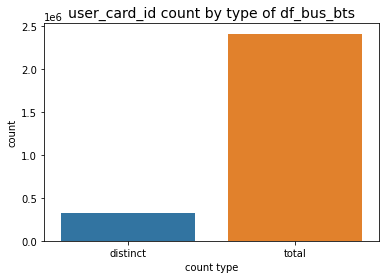

In [51]:
 num_distinct_user_card_id = len(df_bus_bts.user_card_id.value_counts().index)
 num_df_bus_bts = len(df_bus_bts)

dict_user_card_id = dict()
dict_user_card_id["distinct"] = num_distinct_user_card_id
dict_user_card_id["total"] = num_df_bus_bts
df_user_card_id = pd.DataFrame(index=[0],data =dict_user_card_id)

df_user_card_id.reset_index(inplace=True)
df_user_card_id = pd.melt(df_user_card_id,id_vars="index",var_name="count type",value_name="count")
df_user_card_id = df_user_card_id.loc[:,df_user_card_id.columns[1:]]

sns.barplot(data=df_user_card_id,x="count type",y="count")
plt.title("user_card_id count by type of df_bus_bts",fontsize=14)

df_bus_bts의  user_card_id는 고유한 값은 아니다라는 것을 알 수 있다.

### 2. bus_route_id

bus_route_id 컬럼은 bus_bts의 컬럼들 중에서 원본 데이터셋 train과 test set을 함께 고려할 수 있도록 하는 join 대상 컬럼이 된다. 

그런데, 또 주목해야 할 컬럼은 geton_date이다. bus_route_id로 만 join을 했다가는 하나의 df_train의 컬럼에 다른날짜의 승차정보도 포함될 수 있기 때문이다.

그렇다면 getoff_date로는 왜 조인을 하지 않는가? 라고 물어볼 수 있다. 이는 06시~12시 사이에 탑승한 고객이 그날 23시 59분 59초까지 하차하지 않은 경우가 있는 경우에는 고려해 볼만하다. 하지만 그렇지 않을 것 같음을 후에 확인해보자

이 둘을 조인한 후에 bus_route_id와 geton_date로 원하는 결과가 나왔는지 파악하기 위해서는 df_train에서 제공한 시간별 탑승 및 하차의 count 개수와 조인된 row의 개수를 맞춰보는 것이다.

일단 bus_bts의 bus_route_id를 컬럼이 train과 test 컬럼의 bus_route_id와 비교했을 때 누락된 값은 없는지 확인하자, 만약 누락된 값이 있다면 조인의 방식이 달라지기 때문이다.

In [52]:
set_df_train_bus_route_id = set(df_train.bus_route_id)
set_df_bus_bts_bus_route_id = set(df_bus_bts.bus_route_id)

print(f"The number of distinct bus_route_id of df_train is {len(set_df_train_bus_route_id)}")
print(f"The number of distinct bus_route_id of df_bus_bts is {len(set_df_bus_bts_bus_route_id)}")

print(f"The intersection number of distinct bus_route_id of df_bus_bts is {len(set_df_bus_bts_bus_route_id.intersection(set_df_train_bus_route_id))}")
print(f"The intersection number of distinct bus_route_id of df_bus_bts is {len(set_df_bus_bts_bus_route_id.difference(set_df_train_bus_route_id))}")

The number of distinct bus_route_id of df_train is 613
The number of distinct bus_route_id of df_bus_bts is 630
The intersection number of distinct bus_route_id of df_bus_bts is 612
The intersection number of distinct bus_route_id of df_bus_bts is 18


Distinct한 개수가 많은 bus_bts의 기준으로 두 집합의 교집합의 개수는 612개 교집합이 아닌 대상의 개수는 18개이다. 즉 df_train과 bus_bts에서 동일한 bus_route_id 612개 임을 알 수 있다.

그런데, 문제는 df_train에서 Distinct한 bus_route_id의 개수가 613개라는 것이다. 우리의 원 데이터셋 중 1개의 버스 루트는 버스카드 승차정보가 없다는 것을 뜻한다 이를 찾아보자.

In [53]:
set_bus_route_id_only_df_train = set_df_train_bus_route_id.difference(set_df_bus_bts_bus_route_id)
print(f"The only bus_route_id in df_train unlike df_bus_bts is {set_bus_route_id_only_df_train}")

The only bus_route_id in df_train unlike df_bus_bts is {30950000}


In [54]:
bus_route_id_only_df_train = set_bus_route_id_only_df_train.pop()
df_train.loc[df_train.bus_route_id == bus_route_id_only_df_train]

,id,date,bus_route_id,in_out,station_code,station_name,latitude,longitude,6~7_ride,7~8_ride,8~9_ride,9~10_ride,10~11_ride,11~12_ride,6~7_takeoff,7~8_takeoff,8~9_takeoff,9~10_takeoff,10~11_takeoff,11~12_takeoff,18~20_ride
226795,226795,2019-09-17,30950000,시내,141,정부제주지방합동청사,33.49205,126.52738,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
226796,226796,2019-09-17,30950000,시내,271,광양,33.50232,126.52806,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


유일하게 df_train에만 있던 값을 활용하여 원 데이터셋에서 찾아보니, x-y ride와 x-y takeoff의 값들이 모두 0임을 알 수 있었다.

그리하여 우리의 원본 데이터셋 df_train에서 해당 bus_route_id의 값을 살리기 위해 df_train과 df_bus_bts를 left join 방식으로 데이터 프레임을 조인해야 할 것이다.

### <a href="https://advenoh.tistory.com/23">조인(Join</a>)

      출처: https://advenoh.tistory.com/23

  1. JOIN에 대한 기본 개념

  관계형 데이터베이스에서는 중복 데이터를 피하기 위해서 데이터를 쪼개 여러 테이블로 나눠서 저장합니다. 이렇게 분리되어 저장된 데이터에서 원하는 결과를 다시 도출하기 위해서는 여러 테이블을 조합할 필요가 있습니다. 관계형 데이터베이스에서는 조인(JOIN) 연산자를 사용해 관련 있는 컬럼 기준으로 행을 합쳐주는 연산입니다. 

  <img src="https://t1.daumcdn.net/cfile/tistory/99473C435C0D1ECD07" />

  2. 조인의 종류

  * 내부 조진 (INNER JOIN)
  * 교차 조인 (CROSS JOIN  - CARTESIN JOIN)
  * 등가/동등/동일 조인(EQUI JOIN)
  * 비등가 조인(NON-EQUI JOIN)
  * 자연 조인 (NATURAL JOIN)
  * 외부 조인 (OUTER JOIN)
  * 완전 외부 조인 (FULL OUTER JOIN)
  * 왼쪽 (LEFT OUTER)
  * 오른쪽 (RIGHT OUTER)
  * 셀프 조인 (SELF JOIN)
  * 안티 조인 (ANTI JOIN)
  * 세미 조인 (SEMI JOIN)


### 3. vhc_id

  위의 컬럼은 버스카드가 태그된 버스 차량의 ID를 나타낸다. 생각해보면, 특정 버스루트가 굉장히 수요가 많은 루트라면 그에 배차되는 버스의 수도 많다고 생각할 수 있을 것이다. 그리하여 특정 bus_route_id 당 vhc_id의 개수를 파악해보자.

  이를 파악하는데 있어서 단순히 bus_route_id만을 활용하여 vhc_id의 개수를 카운트하면 안될 것 같다. 우리가 가지고 있는 데이터에 맞게 "일별로" 가공하여 사용하자

In [55]:
df_bus_bts.groupby(["bus_route_id","geton_date"])['vhc_id'].count()

# df_bus_bts.set_index(["bus_route_id","geton_date"])["vhc_id"].to_frame()
dummy = df_bus_bts.set_index(["bus_route_id","geton_date","vhc_id"])
dummy.loc[:,"dummy"] = 1
dummy = dummy["dummy"].reset_index()

df_vhc_id_count_by_bus_route_id_and_geton_date = dummy.groupby(["bus_route_id","geton_date","vhc_id"])["dummy"].max().reset_index().groupby(["bus_route_id","geton_date"])["vhc_id"].count().to_frame()
df_vhc_id_count_by_bus_route_id_and_geton_date.head()

vhc_id
bus_route_id geton_date        
4270000      2019-09-01      16
             2019-09-02      17
             2019-09-03      16
             2019-09-04      16
             2019-09-05      17

이제 우리는 위와 같이 해당 버스 루트별로 특정 날짜에 몇대의 버스가 운행했는지 정보를 알 수 있게 되었다.

### 4. geton_date || geton_time & getoff_date || getoff_time

버스에서 승차한 날짜와 하차한 날짜는 앞서 JOIN을 말하며 언급한 컬럼이었다. 여기서 살펴볼 부분은 크게 두 가지이다.

  1. 버스 승차 일자와 시간의 범위 확인
  2. 버스 하차 일자와 시간의 범위 확인

In [56]:
df_bus_bts_get_on_off_date = df_bus_bts.loc[:,["geton_date","getoff_date"]]

print("#"*10,"The information about geton_date")
print(f"null value count of geton_date of df_bus_bts {df_bus_bts_get_on_off_date.geton_date.isnull().sum()}")
print("The min date of getting on the bus is "+df_bus_bts_get_on_off_date["geton_date"].min() +"\nThe max date of getting on the bus is "+df_bus_bts_get_on_off_date["geton_date"].max()+"\n")

df_bus_bts_get_on_off_time = df_bus_bts.loc[:,["geton_time","getoff_time"]]

print("#"*10,"The information about geton_time")
print(f"null value count of geton_time of df_bus_bts {df_bus_bts_get_on_off_time.geton_time.isnull().sum()}")
print("The min time of getting on the bus is "+df_bus_bts_get_on_off_time["geton_time"].min() +"\nThe max time of getting on the bus is "+df_bus_bts_get_on_off_time["geton_time"].max()+"\n")


print("#"*10,"The information about getoff_date")
print(f"null value count of getoff_date of df_bus_bts {df_bus_bts_get_on_off_date.getoff_date.isnull().sum()}")
print("The min date of getting off the bus is "+df_bus_bts_get_on_off_date.loc[~df_bus_bts_get_on_off_date.getoff_date.isnull()]["getoff_date"].min() +"\nThe max date of getting off the bus is "+df_bus_bts_get_on_off_date.loc[~df_bus_bts_get_on_off_date.getoff_date.isnull()]["getoff_date"].max()+"\n")

print("#"*10,"The information about getoff_time")
print(f"null value count of geton_time of df_bus_bts {df_bus_bts_get_on_off_time.getoff_time.isnull().sum()}")
print("The min time of getting off the bus among not null value is "+df_bus_bts_get_on_off_time.loc[~df_bus_bts_get_on_off_time.getoff_time.isnull()].getoff_time.min() +"\nThe max time of getting off the bus among not null value is "+df_bus_bts_get_on_off_time.loc[~df_bus_bts_get_on_off_time.getoff_time.isnull()].getoff_time.max())


########## The information about geton_date
null value count of geton_date of df_bus_bts 0
The min date of getting on the bus is 2019-09-01
The max date of getting on the bus is 2019-10-16

########## The information about geton_time
null value count of geton_time of df_bus_bts 0
The min time of getting on the bus is 06:00:00
The max time of getting on the bus is 11:59:59

########## The information about getoff_date
null value count of getoff_date of df_bus_bts 895736
The min date of getting off the bus is 2019-09-01
The max date of getting off the bus is 2019-10-16

########## The information about getoff_time
null value count of geton_time of df_bus_bts 895736
The min time of getting off the bus among not null value is 06:00:23
The max time of getting off the bus among not null value is 15:53:17


위의 내용을 종합해보면 아래와 같다.

1. 탑승하는 태그에 대한 정보는 모두 null 값이 아니다.
  : 애초에 버스카드 태그에 대한 정보인데, 시작 태그값이 null이면 데이터의 정체성에 문제가 있었을 것이다.

2. 탑승하는 날짜와 시간에 대한 범위는 우리가 원하는 날짜인 2019년 9월 1일부터, 2019년 10월 16일까지의 범위이다. 그리고 시간에 대한 범위는 6시부터 11시 59분 59초 까지 df_train에 나와있는 x-y geton의 정보와 일치하는 것이다.

3. 하차하는 태그에는 null 값 또한 존재한다.
  : 데이터 설명에도 있듯이 하차를 찍지 않으면 date와 time값을 NaN 값으로 설정한다고 되어있다.

그런데, 추가적인 의문점이 든다.
하차 시간태그의 최소값과 최대값을 살펴보자

* 최소값: 06:00:23
* 최대값: 15:53:17

1. 도대체 언제 탑승했길래 하차태그를 06시 00분 23초에 찍을 수 있다는 말인가.. 승차의 최소값은 06시 00분 23초인데 말이다. 종종 승차하자마자 하차때 찍기 귀찮아서 찍는 사람들이나 승차했는데 잘못 탑승해서 다시 내리면서 찍은 경우일 것 같다.

2. 승차시간의 최대값을 보고 느낀점인데, 이를 하차시간의 최대값 15시53분17초를 살펴보자. df_train에는 하차시간도 06시~12시 까지의 정보를 가지고 있는데 여기는 무려 3시간 53분이나 초과된 정보를 가지고 있다. 데이터를 조인하고 가공하면서

  * 12~13 getoff_time
  * 13~14 getoff_time
  * 14~15 getoff_time
  * 15~16 getoff_time

  이라는 컬럼들을 반영해 줄 것인지 생각해 봐야 할 것이다.

탑승시간은 6시에서 11시 59분 59초까지 정확하게 지켜진 것 같지만 하차시간은 그런것 같지도 않았다. 그리고 하차시간에는 하차태그를 하지 않는 경우에는 NaN 처리가 되어 있기 때문에 null value를 제외한 최소값과 최대값을 찾아보았다.

그런데, 하차시간에 대한 의문증은 두 개이다.

#### 1. 굉장히 빠른 하차시간

In [57]:
min_getoff_time = df_bus_bts_get_on_off_time.loc[~df_bus_bts_get_on_off_time.getoff_time.isnull()].getoff_time.min()

df_bus_bts.loc[df_bus_bts.getoff_time == min_getoff_time]

,user_card_id,bus_route_id,vhc_id,geton_date,geton_time,geton_station_code,geton_station_name,getoff_date,getoff_time,getoff_station_code,getoff_station_name,user_category,user_count
261794,1.014140e+15,30290000,149793698,2019-09-04,06:00:17,149,제주버스터미널,2019-09-04,06:00:23,149.0,제주버스터미널,6,1


예측했던 것 대로 잘못 탑승해서 같은 정류장에서 바로 내린 것으로 알 수 있다. geton_station_code와 getoff_station_code가 같기 때문이다. 이들을 fake 탑승자라고 도출하여 새로운 컬럼을 만들고 페이크 탑승자들의 수를 새로운 컬럼으로 주어도 좋을 것 같다.

#### 2. 범위 밖의 하차시간

In [58]:
max_getoff_time = df_bus_bts_get_on_off_time.loc[~df_bus_bts_get_on_off_time.getoff_time.isnull()].getoff_time.max()

df_bus_bts.loc[df_bus_bts.getoff_time == max_getoff_time]

,user_card_id,bus_route_id,vhc_id,geton_date,geton_time,geton_station_code,geton_station_name,getoff_date,getoff_time,getoff_station_code,getoff_station_name,user_category,user_count
1439408,1.014140e+15,22470000,149793049,2019-09-23,11:55:14,748,비자림,2019-09-23,15:53:17,900.0,송당로타리,6,1


### 5. get_on & off station_code

탑승 및 하차 정류장 코드는 df_train에서 시내와 시외를 구분하는 in_out 컬럼과 조합하여 해당 정류장이 시내에 있는지 시외에 있는지 구분하는데 사용하면 좋을 것이다. 조인을 진행해야 하기 때문에 앞에서 사용했던 방법처럼 조인하는 컬럼에 대한 검증이 필요할 것이다.

In [0]:
df_train_station_code_in_out =df_train.loc[:,["station_code","in_out"]]

In [0]:
df_bus_bts_geton_station_code = df_bus_bts.geton_station_code
df_bus_bts_getoff_station_code = df_bus_bts.getoff_station_code

set_df_train_station_code = set(df_train_station_code_in_out["station_code"].value_counts().index)
set_bus_bts_geton_station_code = set(df_bus_bts_geton_station_code.value_counts().index)
set_bus_bts_getoff_station_code = set(df_bus_bts_getoff_station_code.value_counts().index)

In [61]:
print(f"The distinct station code of df_train is {len(set_df_train_station_code)}.\nThe distinct geton_station code of df_bus_bts is {len(set_bus_bts_geton_station_code)}.\nThe distinct getoff_station code of df_bus_bts is {len(set_bus_bts_getoff_station_code)}.")

The distinct station code of df_train is 3563.
The distinct geton_station code of df_bus_bts is 3456.
The distinct getoff_station code of df_bus_bts is 3434.


df_train의 station_code와 비교해 보았을 때, bus_bts에 있는 station_code들의 수가 더 작음을 알 수 있다. 이말은 df_train이 더 많은 station code를 가지고 있으므로 만약 단순한 inner join으로 했다가는 없는 station code에 대한 정보를 잃어버릴 수 있다는 것이다.

그런데,생각해보니... 앞에서는 조인을 실시할 때 date와 bus_route_id만 있으면 된다고 생각했는데... station_code를 활용해야 할 것 같다. 그리고 bus_bts에서 탑승과 하차에 대한 태그가 서로 다르기 때문에 bus_bts에서도 탑승과 하차를 데이터프레임을 분리한 다음에 개별적으로 하나씩 조인을 해주어야 할 것 같다고 생각이든다.

In [0]:
df_bus_bts.head()

df_bus_bts.columns

list_geton = ['user_card_id', 'bus_route_id', 'vhc_id', 'geton_date', 'geton_time',
       'geton_station_code', 'geton_station_name','user_category', 'user_count']
list_getoff = ['user_card_id', 'bus_route_id', 'vhc_id', 'getoff_date',
       'getoff_time', 'getoff_station_code', 'getoff_station_name',
       'user_category', 'user_count']

df_bus_bts_geton = df_bus_bts.loc[:,list_geton]
df_bus_bts_getoff = df_bus_bts.loc[:,list_getoff]

### 6. user_category

해당 카테고리는 탑승 승객이 어떤 부류에 속하는지를 의미하는 컬럼이다

(01-일반, 02-어린이, 04-청소년, 06-경로, 27-장애 일반, 28-장애 동반, 29-유공 일반, 30-유공 동반)

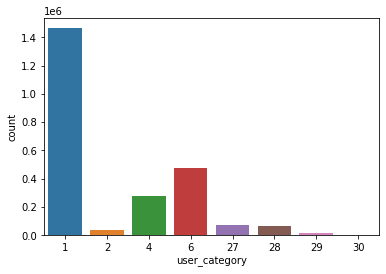

In [63]:
df_bus_bts_user_cat = df_bus_bts.user_category.value_counts().to_frame().reset_index()
df_bus_bts_user_cat.columns = ["user_category","count"]

sns.barplot(x="user_category",y="count",data=df_bus_bts_user_cat)

### 7. user_count

함께 탄 탑승인원을 뜻한다.

In [64]:
print(f"The maximum of user_count is {df_bus_bts.user_count.max()}.\nThe mininum of user_count is {df_bus_bts.user_count.min()}.")

The maximum of user_count is 10.
The mininum of user_count is 1.


## Data Cleaning

앞에서 생각했던 인사이트를 토대로 데이터를 가공해보자.

버스 승차정보 데이터를 가공함에 있어서 사용될 기준 컬럼은 아래와 같으며
* geton/off date
* bus_route_id
* geton/off station_code. 
* latitude & longitude

이 세개의 컬럼을 인덱스로 하여 데이터를 합치고 나누는  Data Cleaning 작업을 할 것이다.

Cleaning 작업은 아래와 같다.

1. input column 시간대와 target column 시간대의 일치 - from baseline code
2. 탑승인원 계산법 검증
3. 해당 날짜에 해당 버스가 특정 승차장을 거쳐간 횟수 (geton and getoff)
4. 카테고리별 탑승인원
5. location 데이터를 활용한 categorical한 데이터 추출 - from baseline code


In [65]:
df_train.head()

,id,date,bus_route_id,in_out,station_code,station_name,latitude,longitude,6~7_ride,7~8_ride,8~9_ride,9~10_ride,10~11_ride,11~12_ride,6~7_takeoff,7~8_takeoff,8~9_takeoff,9~10_takeoff,10~11_takeoff,11~12_takeoff,18~20_ride
0,0,2019-09-01,4270000,시외,344,제주썬호텔,33.48990,126.49373,0.0,1.0,2.0,5.0,2.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,2019-09-01,4270000,시외,357,한라병원,33.48944,126.48508,1.0,4.0,4.0,2.0,5.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0
2,2,2019-09-01,4270000,시외,432,정존마을,33.48181,126.47352,1.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
3,3,2019-09-01,4270000,시내,1579,제주국제공항(600번),33.50577,126.49252,0.0,17.0,6.0,26.0,14.0,16.0,0.0,0.0,0.0,0.0,0.0,0.0,53.0
4,4,2019-09-01,4270000,시내,1646,중문관광단지입구,33.25579,126.41260,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [0]:
df_bus_bts_geton.head()

df_bus_bts_geton2 = df_bus_bts_geton.copy()

In [0]:
df_bus_bts_getoff.head()

df_bus_bts_getoff2 = df_bus_bts_getoff.copy()

### 1. input column 시간 간격과 target column 시간 간격대 통일 - from baseline code

In [0]:
df_train_chg_time_line = df_train.copy()
df_train_chg_time_line = df_train_chg_time_line.drop(columns=df_train.columns[-13:-1],axis=1)
df_train_chg_time_line["6~8_ride"] = df_train["6~7_ride"] + df_train["7~8_ride"]
df_train_chg_time_line["8~10_ride"] = df_train["8~9_ride"] + df_train["9~10_ride"]
df_train_chg_time_line["10~12_ride"] = df_train["10~11_ride"] + df_train["11~12_ride"]
df_train_chg_time_line["6~8_takeoff"] = df_train["6~7_takeoff"] + df_train["7~8_takeoff"]
df_train_chg_time_line["8~10_takeoff"] = df_train["8~9_takeoff"] + df_train["9~10_takeoff"]
df_train_chg_time_line["10~12_takeoff"] = df_train["10~11_takeoff"] + df_train["11~12_takeoff"]

df_test_chg_time_line = df_test.copy()
df_test_chg_time_line = df_test_chg_time_line.drop(columns=df_train.columns[-13:-1],axis=1)
df_test_chg_time_line["6~8_ride"] = df_test["6~7_ride"] + df_test["7~8_ride"]
df_test_chg_time_line["8~10_ride"] = df_test["8~9_ride"] + df_test["9~10_ride"]
df_test_chg_time_line["10~12_ride"] = df_test["10~11_ride"] + df_test["11~12_ride"]
df_test_chg_time_line["6~8_takeoff"] = df_test["6~7_takeoff"] + df_test["7~8_takeoff"]
df_test_chg_time_line["8~10_takeoff"] = df_test["8~9_takeoff"] + df_test["9~10_takeoff"]
df_test_chg_time_line["10~12_takeoff"] = df_test["10~11_takeoff"] + df_test["11~12_takeoff"]

In [0]:
target = df_train_chg_time_line["18~20_ride"]
df_train2 = pd.concat([df_train_chg_time_line.drop("18~20_ride",axis=1),target],axis=1)
df_test2 = df_test_chg_time_line

### 2. 탑승 및 하차 인원 계산법 검증

탑승과 하차 인원은 어떻게 계산되는 것일까? 버스카드 태그 정보에서 승차태그 및 하차태그의 시간대만 땐 다음에 user_count의 합인지 또는 태그한 user_card_id의 합인지 확인해보자 

In [0]:
list_df_train_index_col = ["date","bus_route_id","station_code"]
list_df_bus_bts_geton_index_col = ["geton_date","bus_route_id","geton_station_code"]
list_df_bus_bts_getoff_index_col = ["getoff_date","bus_route_id","getoff_station_code"]
list_df_bus_bts_geton_index_values = df_bus_bts.loc[df_bus_bts.user_count != 1].head(1)[list_df_bus_bts_geton_index_col].values

In [71]:
df_train.loc[np.logical_and(np.logical_and(df_train.date==list_df_bus_bts_geton_index_values[0][0],df_train.bus_route_id==list_df_bus_bts_geton_index_values[0][1]),df_train.station_code==list_df_bus_bts_geton_index_values[0][2])]

,id,date,bus_route_id,in_out,station_code,station_name,latitude,longitude,6~7_ride,7~8_ride,8~9_ride,9~10_ride,10~11_ride,11~12_ride,6~7_takeoff,7~8_takeoff,8~9_takeoff,9~10_takeoff,10~11_takeoff,11~12_takeoff,18~20_ride
136361,136361,2019-09-10,29640000,시내,1503,한마음병원,33.496,126.54735,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [72]:
df_bus_bts_geton.loc[np.logical_and(np.logical_and(df_bus_bts_geton.geton_date==list_df_bus_bts_geton_index_values[0][0],df_bus_bts_geton.bus_route_id==list_df_bus_bts_geton_index_values[0][1]),df_bus_bts_geton.geton_station_code== list_df_bus_bts_geton_index_values[0][2])]

,user_card_id,bus_route_id,vhc_id,geton_date,geton_time,geton_station_code,geton_station_name,user_category,user_count
117,1.019160e+15,29640000,149793538,2019-09-10,07:49:58,1503,한마음병원,1,2


검증을 위해 df_bus_bts_geton에서 user_count가 1이 아닌 것 중 가장 상단의 인덱스 값을 활용하여 train 값에서 확인 해본 결과. user_count의 합이 take_off나 take_on에 반영되는 것으로 확인했다. 그리하여 geton / off time 값에 time_converter 함수를 활용하여 train, test 셋에 있는 것처럼 timeline 별로 쪼개서 하나의 컬럼으로 관리한다.

In [0]:
def time_converter(str_time,is_geton=True):
  
  result = ""

  if is_geton:

    add_str = "_ride"

    if str_time >= '06:00:00' and str_time < '07:00:00':
      result = f"6~7{add_str}"
    elif str_time >= '07:00:00' and str_time < '08:00:00':
      result = f"7~8{add_str}"
    elif str_time >= '08:00:00' and str_time < '09:00:00':
      result = f"8~9{add_str}"
    elif str_time >= '09:00:00' and str_time < '10:00:00':
      result = f"9~10{add_str}"
    elif str_time >= '10:00:00' and str_time < '11:00:00':
      result = f"10~11{add_str}"
    elif str_time >= '11:00:00' and str_time < '12:00:00':
      result = f"11~12{add_str}"

  else:

    add_str = "_takeoff"

    if str_time is None:
      result = "NaN"
    elif str_time >= '06:00:00' and str_time < '07:00:00':
      result = f"6~7{add_str}"
    elif str_time >= '07:00:00' and str_time < '08:00:00':
      result = f"7~8{add_str}"
    elif str_time >= '08:00:00' and str_time < '09:00:00':
      result = f"8~9{add_str}"
    elif str_time >= '09:00:00' and str_time < '10:00:00':
      result = f"9~10{add_str}"
    elif str_time >= '10:00:00' and str_time < '11:00:00':
      result = f"10~11{add_str}"
    elif str_time >= '11:00:00' and str_time < '12:00:00':
      result = f"11~12{add_str}"
    elif str_time >= '12:00:00' and str_time < '13:00:00':
      result = f"12~13{add_str}"
    elif str_time >= '13:00:00' and str_time < '14:00:00':
      result = f"13~14{add_str}"
    elif str_time >= '14:00:00' and str_time < '15:00:00':
      result = f"14~15{add_str}"
    elif str_time >= '15:00:00' and str_time < '16:00:00':
      result = f"15~16{add_str}"

  return result

In [0]:
df_bus_bts_geton["geton_timeline"] = df_bus_bts_geton.geton_time.apply(lambda x:time_converter(x,True))
df_bus_bts_getoff.loc[~df_bus_bts_getoff.getoff_time.isnull(),"getoff_timeline"] = df_bus_bts_getoff.loc[~df_bus_bts_getoff.getoff_time.isnull()].getoff_time.apply(lambda x:time_converter(x,False))

In [0]:
df_bus_bts_geton_rider_by_timeline = pd.pivot_table(data=df_bus_bts_geton,index=list_df_bus_bts_geton_index_col,columns="geton_timeline",values="user_count",aggfunc=np.sum)
list_reorder_column = [ '6~7_ride', '7~8_ride',
       '8~9_ride', '9~10_ride','10~11_ride', '11~12_ride']
df_bus_bts_geton_rider_by_timeline = df_bus_bts_geton_rider_by_timeline.loc[:,list_reorder_column]

In [0]:
df_bus_bts_getoff_rider_by_timeline = pd.pivot_table(data=df_bus_bts_getoff,index=list_df_bus_bts_getoff_index_col,columns="getoff_timeline",values="user_count",aggfunc=np.sum)
#reorder column
list_reorder_column = [ '6~7_takeoff', '7~8_takeoff',
       '8~9_takeoff', '9~10_takeoff','10~11_takeoff', '11~12_takeoff', '12~13_takeoff', '13~14_takeoff',
       '14~15_takeoff', '15~16_takeoff']
df_bus_bts_getoff_rider_by_timeline = df_bus_bts_getoff_rider_by_timeline.loc[:, list_reorder_column]

우리는 1번 작업을 통해 df_bus_bts_get on / off_rider_by_timeline 데이터를 얻었다. getoff의 경우에는 우리가 위에서 인사이트를 통해 얻었던 15시 53분경 하차한 사람의 데이터 또한 얻어냈다.


2020-03-18(수) timeline ver 추가

In [0]:
def time_converter2(str_time,is_geton=True):
  
  result = ""

  if is_geton:

    add_str = "_ride"

    if str_time >= '06:00:00' and str_time < '08:00:00':
      result = f"6~8{add_str}"
    elif str_time >= '08:00:00' and str_time < '10:00:00':
      result = f"8~10{add_str}"
    elif str_time >= '10:00:00' and str_time < '12:00:00':
      result = f"10~12{add_str}"

  else:

    add_str = "_takeoff"

    if str_time is None:
      result = "NaN"
    elif str_time >= '06:00:00' and str_time < '08:00:00':
      result = f"6~8{add_str}"
    elif str_time >= '08:00:00' and str_time < '10:00:00':
      result = f"8~10{add_str}"
    elif str_time >= '10:00:00' and str_time < '12:00:00':
      result = f"10~12{add_str}"
    elif str_time >= '12:00:00' and str_time < '14:00:00':
      result = f"12~14{add_str}"
    elif str_time >= '14:00:00' and str_time < '16:00:00':
      result = f"14~16{add_str}"
    
  return result

In [0]:
df_bus_bts_geton2["geton_timeline"] = df_bus_bts_geton2.geton_time.apply(lambda x:time_converter2(x,True))
df_bus_bts_getoff2.loc[~df_bus_bts_getoff2.getoff_time.isnull(),"getoff_timeline"] = df_bus_bts_getoff2.loc[~df_bus_bts_getoff2.getoff_time.isnull()].getoff_time.apply(lambda x:time_converter2(x,False))

df_bus_bts_geton2_rider_by_timeline = pd.pivot_table(data=df_bus_bts_geton2,index=list_df_bus_bts_geton_index_col,columns="geton_timeline",values="user_count",aggfunc=np.sum)
list_reorder_column = [ '6~8_ride',
       '8~10_ride','10~12_ride']
df_bus_bts_geton2_rider_by_timeline = df_bus_bts_geton2_rider_by_timeline.loc[:,list_reorder_column]

df_bus_bts_getoff2_rider_by_timeline = pd.pivot_table(data=df_bus_bts_getoff2,index=list_df_bus_bts_getoff_index_col,columns="getoff_timeline",values="user_count",aggfunc=np.sum)
#reorder column
list_reorder_column = [ '6~8_takeoff',
       '8~10_takeoff','10~12_takeoff', '12~14_takeoff',
       '14~16_takeoff']
df_bus_bts_getoff2_rider_by_timeline = df_bus_bts_getoff2_rider_by_timeline.loc[:, list_reorder_column]

### 2. 특정 날짜에 어느 노선의 특정 정류장을 거쳐간 버스의 대수

버스카드 승하차 태그 데이터에는 vhc_id 라는 차량을 구분하는 id가 있다. 만약 승하차 수요가 높은 곳이라면, 지나가는 버스의 수도 많을 수 있다고 생각한다.

In [79]:
df_bus_bts_geton_passby = df_bus_bts_geton.groupby(list_df_bus_bts_geton_index_col)["vhc_id"].nunique().to_frame()
df_bus_bts_geton_passby.columns = ["geton_vhc_passby_count"]
df_bus_bts_geton_passby.head()

geton_vhc_passby_count
geton_date bus_route_id geton_station_code                        
2019-09-01 4270000      344                                      7
                        357                                     10
                        432                                      4
                        1579                                    13
                        1648                                     1

In [80]:
df_bus_bts_getoff_passby = df_bus_bts_getoff.groupby(list_df_bus_bts_getoff_index_col)["vhc_id"].nunique().to_frame()
df_bus_bts_getoff_passby.columns = ["getoff_vhc_passby_count"]
df_bus_bts_getoff_passby.head()

getoff_vhc_passby_count
getoff_date bus_route_id getoff_station_code                         
2019-09-01  4270000      1636.0                                     1
                         1646.0                                     1
                         1648.0                                     2
                         1660.0                                     3
                         1666.0                                     1

### 3. 카테고리별 승차 인원

 우리의 train set에서는 특정 시간대에 탑승하는 인원 수를 제공하고 있다. 그렇다면, 특정 시간대에 탑승하는 카테고리별 승차인원을 반영하는 컬럼을 만들어보는 것도 좋을 것이라고 생각한다.

In [0]:
df_bus_bts_geton_cat_people = pd.pivot_table(data=df_bus_bts_geton, index=["geton_date","bus_route_id","geton_station_code"],columns=["geton_timeline","user_category"], values="user_count",aggfunc=np.sum)
df_bus_bts_getoff_cat_people = pd.pivot_table(data=df_bus_bts_getoff, index=["getoff_date","bus_route_id","getoff_station_code"],columns=["getoff_timeline","user_category"], values="user_count",aggfunc=np.sum)

In [82]:
df_bus_bts_geton_cat_people.head()

geton_timeline                             10~11_ride          ... 9~10_ride        
user_category                                      1   2   4   ...        28  29  30
geton_date bus_route_id geton_station_code                     ...                  
2019-09-01 4270000      344                       2.0 NaN NaN  ...       NaN NaN NaN
                        357                       5.0 NaN NaN  ...       NaN NaN NaN
                        432                       NaN NaN NaN  ...       NaN NaN NaN
                        1579                     14.0 NaN NaN  ...       NaN NaN NaN
                        1648                      1.0 NaN NaN  ...       NaN NaN NaN

[5 rows x 48 columns]

In [83]:
df_bus_bts_getoff_cat_people.head()

getoff_timeline                              10~11_takeoff          ... 9~10_takeoff        
user_category                                           1   2   4   ...           28  29  30
getoff_date bus_route_id getoff_station_code                        ...                     
2019-09-01  4270000      1636.0                        NaN NaN NaN  ...          NaN NaN NaN
                         1646.0                        NaN NaN NaN  ...          NaN NaN NaN
                         1648.0                        1.0 NaN NaN  ...          NaN NaN NaN
                         1660.0                        1.0 NaN NaN  ...          NaN NaN NaN
                         1666.0                        NaN NaN NaN  ...          NaN NaN NaN

[5 rows x 75 columns]

2020-03-18(수) timeline ver 추가

In [0]:
df_bus_bts_geton2_cat_people = pd.pivot_table(data=df_bus_bts_geton2, index=["geton_date","bus_route_id","geton_station_code"],columns=["geton_timeline","user_category"], values="user_count",aggfunc=np.sum)
df_bus_bts_getoff2_cat_people = pd.pivot_table(data=df_bus_bts_getoff2, index=["getoff_date","bus_route_id","getoff_station_code"],columns=["getoff_timeline","user_category"], values="user_count",aggfunc=np.sum)

In [85]:
df_bus_bts_geton2_cat_people.head()

geton_timeline                             10~12_ride          ... 8~10_ride        
user_category                                      1   2   4   ...        28  29  30
geton_date bus_route_id geton_station_code                     ...                  
2019-09-01 4270000      344                       8.0 NaN NaN  ...       NaN NaN NaN
                        357                      11.0 NaN NaN  ...       NaN NaN NaN
                        432                       NaN NaN NaN  ...       NaN NaN NaN
                        1579                     30.0 NaN NaN  ...       NaN NaN NaN
                        1648                      1.0 NaN NaN  ...       NaN NaN NaN

[5 rows x 24 columns]

In [86]:
df_bus_bts_getoff2_cat_people.head()

getoff_timeline                              10~12_takeoff          ... 8~10_takeoff        
user_category                                           1   2   4   ...           28  29  30
getoff_date bus_route_id getoff_station_code                        ...                     
2019-09-01  4270000      1636.0                        NaN NaN NaN  ...          NaN NaN NaN
                         1646.0                        NaN NaN NaN  ...          NaN NaN NaN
                         1648.0                        1.0 NaN NaN  ...          NaN NaN NaN
                         1660.0                        6.0 NaN NaN  ...          NaN NaN NaN
                         1666.0                        NaN NaN NaN  ...          NaN NaN NaN

[5 rows x 39 columns]

#### 4. location 데이터를 활용한 categorical한 데이터 추출 - from baseline code

In [87]:
num_unique_station_code_count = len(df_train.station_code.value_counts().index)
num_unique_station_name_count = len(df_train.station_name.value_counts().index)

print(f"unique station code value is {num_unique_station_code_count}.\nunique station name value is {num_unique_station_name_count}.")

unique station code value is 3563.
unique station name value is 1961.


In [88]:
df_train.groupby("station_name")["station_code"].nunique()

station_name
(구)구판장        2
(구)중문동주민센터    2
(구)중앙파출소      3
(구)화산초등학교     2
1100고지휴게소     2
             ..
흙통            2
흥국사           2
흥덕사           2
희진주유소         2
히귀반석          1
Name: station_code, Length: 1961, dtype: int64

In [0]:
list_distance_from_jeju = [geopy.distance.vincenty((i,j),jeju).km for i,j in list(zip(df_train["latitude"],df_train["longitude"]))]
list_distance_from_gosan = [geopy.distance.vincenty((i,j),gosan).km for i,j in list(zip(df_train["latitude"],df_train["longitude"]))]
list_distance_from_seongsan = [geopy.distance.vincenty((i,j),seongsan).km for i,j in list(zip(df_train["latitude"],df_train["longitude"]))]
list_distance_from_po = [geopy.distance.vincenty((i,j),po).km for i,j in list(zip(df_train["latitude"],df_train["longitude"]))]

df_train_distance_per_locations = df_train.copy()
df_train_distance_per_locations["jeju"]  = list_distance_from_jeju
df_train_distance_per_locations["gosan"] = list_distance_from_gosan
df_train_distance_per_locations["seongsan"] = list_distance_from_seongsan
df_train_distance_per_locations["po"] = list_distance_from_po

In [90]:
df_train_distance_per_locations["nearest_loc"] = df_train_distance_per_locations.loc[:,df_train_distance_per_locations.columns[-4:]].idxmin(axis=1)
df_train_distance_per_locations.head()

,id,date,bus_route_id,in_out,station_code,station_name,latitude,longitude,6~7_ride,7~8_ride,8~9_ride,9~10_ride,10~11_ride,11~12_ride,6~7_takeoff,7~8_takeoff,8~9_takeoff,9~10_takeoff,10~11_takeoff,11~12_takeoff,18~20_ride,jeju,gosan,seongsan,po,nearest_loc
0,0,2019-09-01,4270000,시외,344,제주썬호텔,33.48990,126.49373,0.0,1.0,2.0,5.0,2.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.286659,37.692766,37.713630,27.841879,jeju
1,1,2019-09-01,4270000,시외,357,한라병원,33.48944,126.48508,1.0,4.0,4.0,2.0,5.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,4.966848,37.008492,38.465822,27.996179,jeju
2,2,2019-09-01,4270000,시외,432,정존마을,33.48181,126.47352,1.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,6.330746,35.642126,39.259820,27.496551,jeju
3,3,2019-09-01,4270000,시내,1579,제주국제공항(600번),33.50577,126.49252,0.0,17.0,6.0,26.0,14.0,16.0,0.0,0.0,0.0,0.0,0.0,0.0,53.0,3.575272,38.643401,38.386802,29.579404,jeju
4,4,2019-09-01,4270000,시내,1646,중문관광단지입구,33.25579,126.41260,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,30.652098,23.648361,45.899140,14.269792,po


In [0]:
encoder = OneHotEncoder()

df_train_result = encoder.fit_transform(df_train_distance_per_locations["nearest_loc"].values.reshape(-1,1))
list_encoded_columns = list(map(lambda x:re.sub("x0_","",x),encoder.get_feature_names()))

df_train_endcoded_distance_per_locations = pd.DataFrame(df_train_result.todense(),columns=list_encoded_columns)
df_train_endcoded_distance_per_locations = df_train_endcoded_distance_per_locations.astype("int")

In [0]:
list_distance_from_jeju = [geopy.distance.vincenty((i,j),jeju).km for i,j in list(zip(df_test["latitude"],df_test["longitude"]))]
list_distance_from_gosan = [geopy.distance.vincenty((i,j),gosan).km for i,j in list(zip(df_test["latitude"],df_test["longitude"]))]
list_distance_from_seongsan = [geopy.distance.vincenty((i,j),seongsan).km for i,j in list(zip(df_test["latitude"],df_test["longitude"]))]
list_distance_from_po = [geopy.distance.vincenty((i,j),po).km for i,j in list(zip(df_test["latitude"],df_test["longitude"]))]

df_test_distance_per_locations = df_test.copy()
df_test_distance_per_locations["jeju"]  = list_distance_from_jeju
df_test_distance_per_locations["gosan"] = list_distance_from_gosan
df_test_distance_per_locations["seongsan"] = list_distance_from_seongsan
df_test_distance_per_locations["po"] = list_distance_from_po

In [93]:
df_test_distance_per_locations["nearest_loc"] = df_test_distance_per_locations.loc[:,df_test_distance_per_locations.columns[-4:]].idxmin(axis=1)
df_test_distance_per_locations.head()

,id,date,bus_route_id,in_out,station_code,station_name,latitude,longitude,6~7_ride,7~8_ride,8~9_ride,9~10_ride,10~11_ride,11~12_ride,6~7_takeoff,7~8_takeoff,8~9_takeoff,9~10_takeoff,10~11_takeoff,11~12_takeoff,jeju,gosan,seongsan,po,nearest_loc
0,415423,2019-10-01,4270000,시외,344,제주썬호텔,33.48990,126.49373,4.0,4.0,7.0,2.0,9.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,4.286659,37.692766,37.713630,27.841879,jeju
1,415424,2019-10-01,4270000,시외,357,한라병원,33.48944,126.48508,1.0,6.0,6.0,1.0,8.0,11.0,0.0,0.0,0.0,0.0,0.0,0.0,4.966848,37.008492,38.465822,27.996179,jeju
2,415425,2019-10-01,4270000,시외,432,정존마을,33.48181,126.47352,2.0,4.0,2.0,2.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,6.330746,35.642126,39.259820,27.496551,jeju
3,415426,2019-10-01,4270000,시내,1579,제주국제공항(600번),33.50577,126.49252,1.0,11.0,18.0,8.0,26.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,3.575272,38.643401,38.386802,29.579404,jeju
4,415427,2019-10-01,4270000,시내,1636,롯데호텔,33.24872,126.41032,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,31.460686,23.594010,46.355301,14.445605,po


In [0]:
df_test_result = encoder.transform(df_test_distance_per_locations["nearest_loc"].values.reshape(-1,1))
list_encoded_columns = list(map(lambda x:re.sub("x0_","",x),encoder.get_feature_names()))

df_test_endcoded_distance_per_locations = pd.DataFrame(df_test_result.todense(),columns=list_encoded_columns)
df_test_endcoded_distance_per_locations = df_test_endcoded_distance_per_locations.astype("int")

### 4. Merge DataFrames

해당 섹션에서는 인사이트를 얻어낸 것을 바탕으로 여러개의 데이터프레임을 train 및 test 데이터셋을 위한 데이터 형태로 변형합니다.

#### 1. input data와 target data의 분리

In [0]:
y_target = df_train["18~20_ride"]
X_train = df_train.loc[:,df_train.columns[:-1]]
X_test = df_test

In [96]:
X_train.head()

,id,date,bus_route_id,in_out,station_code,station_name,latitude,longitude,6~7_ride,7~8_ride,8~9_ride,9~10_ride,10~11_ride,11~12_ride,6~7_takeoff,7~8_takeoff,8~9_takeoff,9~10_takeoff,10~11_takeoff,11~12_takeoff
0,0,2019-09-01,4270000,시외,344,제주썬호텔,33.48990,126.49373,0.0,1.0,2.0,5.0,2.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,2019-09-01,4270000,시외,357,한라병원,33.48944,126.48508,1.0,4.0,4.0,2.0,5.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,2019-09-01,4270000,시외,432,정존마을,33.48181,126.47352,1.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,2019-09-01,4270000,시내,1579,제주국제공항(600번),33.50577,126.49252,0.0,17.0,6.0,26.0,14.0,16.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,2019-09-01,4270000,시내,1646,중문관광단지입구,33.25579,126.41260,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


2020-03-16(월) geological category data

In [0]:
y_target2 = df_train["18~20_ride"]
X_train2 = df_train.loc[:,df_train.columns[:-1]]
X_test2 = df_test

2020-03-18(수) timeline ver 추가

In [0]:
y_target3 = df_train2["18~20_ride"]
X_train3 = df_train2.loc[:,df_train2.columns[:-1]]
X_test3 = df_test2

#### 2. 요일 / 주말 / 공휴일 정보 merge

In [0]:
def weekday_converter(value):
  if value == "weekday":
    return True
  else:
    return False

In [100]:
df_train_test_date =df_train_test_date.loc[:,["date","day_name","day_type"]]
df_train_test_date["is_weekday"] = df_train_test_date.day_type.apply(lambda x: weekday_converter(x)) 
df_train_test_date = df_train_test_date.loc[:,["date","day_name","is_weekday"]]
df_train_test_date.head()

,date,day_name,is_weekday
0,2019-09-01,Sun,False
1,2019-09-02,Mon,True
2,2019-09-03,Tue,True
3,2019-09-04,Wed,True
4,2019-09-05,Thr,True


In [0]:
df_merged_X_train = pd.merge(left=X_train,right=df_train_test_date,on="date")
assert df_train.shape[0] ==df_merged_X_train.shape[0]

df_merged_X_test = pd.merge(left=X_test,right=df_train_test_date,on="date")
assert df_test.shape[0] ==df_merged_X_test.shape[0]

assert df_merged_X_train.shape[1] == df_merged_X_test.shape[1]

In [0]:
df_merged_X_train2 = pd.merge(left=X_train2,right=df_train_test_date,on="date")
assert df_train.shape[0] ==df_merged_X_train2.shape[0]

df_merged_X_test2 = pd.merge(left=X_test2,right=df_train_test_date,on="date")
assert df_test.shape[0] ==df_merged_X_test2.shape[0]

assert df_merged_X_train2.shape[1] == df_merged_X_test2.shape[1]

In [0]:
df_merged_X_train3 = pd.merge(left=X_train3,right=df_train_test_date,on="date")
assert df_train2.shape[0] ==df_merged_X_train3.shape[0]

df_merged_X_test3 = pd.merge(left=X_test3,right=df_train_test_date,on="date")
assert df_test2.shape[0] ==df_merged_X_test3.shape[0]

assert df_merged_X_train3.shape[1] == df_merged_X_test3.shape[1]

#### 3. 위도와 경도를 활용한 4구역 분할 데이터 결합 (2020-03-16[월])

In [0]:
df_merged_X_train2 = pd.concat([df_merged_X_train2,df_train_endcoded_distance_per_locations],axis=1)
df_merged_X_test2 = pd.concat([df_merged_X_test2,df_test_endcoded_distance_per_locations],axis=1)

In [0]:
df_merged_X_train3 = pd.concat([df_merged_X_train3,df_train_endcoded_distance_per_locations],axis=1)
df_merged_X_test3 = pd.concat([df_merged_X_test3,df_test_endcoded_distance_per_locations],axis=1)

#### 4. 시간 구간별 탑승 / 하차자 count 정보 merge

In [106]:
df_bus_bts_geton_rider_by_timeline = df_bus_bts_geton_rider_by_timeline.fillna(value=0).reset_index()
df_bus_bts_geton_rider_by_timeline.head()

geton_timeline,geton_date,bus_route_id,geton_station_code,6~7_ride,7~8_ride,8~9_ride,9~10_ride,10~11_ride,11~12_ride
0,2019-09-01,4270000,344,0.0,1.0,2.0,5.0,2.0,6.0
1,2019-09-01,4270000,357,1.0,4.0,4.0,2.0,5.0,6.0
2,2019-09-01,4270000,432,1.0,1.0,0.0,2.0,0.0,0.0
3,2019-09-01,4270000,1579,0.0,17.0,6.0,26.0,14.0,16.0
4,2019-09-01,4270000,1648,0.0,0.0,0.0,0.0,1.0,0.0


In [107]:
df_bus_bts_getoff_rider_by_timeline = df_bus_bts_getoff_rider_by_timeline.fillna(value=0).reset_index()
df_bus_bts_getoff_rider_by_timeline.head()

getoff_timeline,getoff_date,bus_route_id,getoff_station_code,6~7_takeoff,7~8_takeoff,8~9_takeoff,9~10_takeoff,10~11_takeoff,11~12_takeoff,12~13_takeoff,13~14_takeoff,14~15_takeoff,15~16_takeoff
0,2019-09-01,4270000,1636.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,2019-09-01,4270000,1646.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2019-09-01,4270000,1648.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,2019-09-01,4270000,1660.0,0.0,0.0,0.0,0.0,1.0,5.0,0.0,0.0,0.0,0.0
4,2019-09-01,4270000,1666.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [0]:
df_merged_X_train = pd.merge(left=df_merged_X_train, right=df_bus_bts_geton_rider_by_timeline, left_on=list_df_train_index_col, right_on=list_df_bus_bts_geton_index_col, how="left")
assert df_train.shape[0] ==df_merged_X_train.shape[0]

df_merged_X_test = pd.merge(left=df_merged_X_test, right=df_bus_bts_geton_rider_by_timeline, left_on=list_df_train_index_col, right_on=list_df_bus_bts_geton_index_col, how="left")
assert df_test.shape[0] ==df_merged_X_test.shape[0]

assert df_merged_X_train.shape[1] == df_merged_X_test.shape[1]

In [0]:
df_merged_X_train = pd.merge(left=df_merged_X_train, right=df_bus_bts_getoff_rider_by_timeline, left_on=list_df_train_index_col, right_on=list_df_bus_bts_getoff_index_col, how="left")
assert df_train.shape[0] ==df_merged_X_train.shape[0]

df_merged_X_test = pd.merge(left=df_merged_X_test, right=df_bus_bts_getoff_rider_by_timeline, left_on=list_df_train_index_col, right_on=list_df_bus_bts_getoff_index_col, how="left")
assert df_test.shape[0] ==df_merged_X_test.shape[0]

assert df_merged_X_train.shape[1] == df_merged_X_test.shape[1]

In [0]:
import re 

r = re.compile(".*_y")
list_column_y = list(filter(r.match, df_merged_X_train)) # Read Note

for column in df_merged_X_train.columns[-4:]:
  list_column_y.append(column)

for column in list_column_y:
  df_merged_X_train[column].fillna(value=0,inplace=True)
  df_merged_X_test[column].fillna(value=0,inplace=True)

In [111]:
df_merged_X_train.head()

,id,date,bus_route_id,in_out,station_code,station_name,latitude,longitude,6~7_ride_x,7~8_ride_x,8~9_ride_x,9~10_ride_x,10~11_ride_x,11~12_ride_x,6~7_takeoff_x,7~8_takeoff_x,8~9_takeoff_x,9~10_takeoff_x,10~11_takeoff_x,11~12_takeoff_x,day_name,is_weekday,geton_date,geton_station_code,6~7_ride_y,7~8_ride_y,8~9_ride_y,9~10_ride_y,10~11_ride_y,11~12_ride_y,getoff_date,getoff_station_code,6~7_takeoff_y,7~8_takeoff_y,8~9_takeoff_y,9~10_takeoff_y,10~11_takeoff_y,11~12_takeoff_y,12~13_takeoff,13~14_takeoff,14~15_takeoff,15~16_takeoff
0,0,2019-09-01,4270000,시외,344,제주썬호텔,33.48990,126.49373,0.0,1.0,2.0,5.0,2.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,Sun,False,2019-09-01,344.0,0.0,1.0,2.0,5.0,2.0,6.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,2019-09-01,4270000,시외,357,한라병원,33.48944,126.48508,1.0,4.0,4.0,2.0,5.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,Sun,False,2019-09-01,357.0,1.0,4.0,4.0,2.0,5.0,6.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,2019-09-01,4270000,시외,432,정존마을,33.48181,126.47352,1.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Sun,False,2019-09-01,432.0,1.0,1.0,0.0,2.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,2019-09-01,4270000,시내,1579,제주국제공항(600번),33.50577,126.49252,0.0,17.0,6.0,26.0,14.0,16.0,0.0,0.0,0.0,0.0,0.0,0.0,Sun,False,2019-09-01,1579.0,0.0,17.0,6.0,26.0,14.0,16.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,2019-09-01,4270000,시내,1646,중문관광단지입구,33.25579,126.41260,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,Sun,False,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,2019-09-01,1646.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [112]:
r = re.compile(".*_x")
list_column_x = list(filter(r.match, df_merged_X_train))

r = re.compile(".*_y")
list_column_y = list(filter(r.match, df_merged_X_train))

assert len(list_column_x) == len(list_column_y)
print(len(list_column_x))

12


In [113]:
for idx,element in enumerate(list_column_x):
  equal_num = (df_merged_X_train[element] == df_merged_X_train[list_column_y[idx]]).sum()

  if equal_num != 415423:
    print(f"equal num of {element} is  {equal_num} with _y column, total_num is {df_merged_X_train.shape[0]}")

equal num of 6~7_takeoff_x is  412101 with _y column, total_num is 415423
equal num of 7~8_takeoff_x is  414777 with _y column, total_num is 415423
equal num of 8~9_takeoff_x is  415413 with _y column, total_num is 415423
equal num of 9~10_takeoff_x is  415421 with _y column, total_num is 415423


2020-03-16(월) 위도, 경도 데이터 4분할 카테고리 값 추가

In [114]:
df_merged_X_train2 = pd.merge(left=df_merged_X_train2, right=df_bus_bts_geton_rider_by_timeline, left_on=list_df_train_index_col, right_on=list_df_bus_bts_geton_index_col, how="left")
assert df_train.shape[0] ==df_merged_X_train2.shape[0]

df_merged_X_test2 = pd.merge(left=df_merged_X_test2, right=df_bus_bts_geton_rider_by_timeline, left_on=list_df_train_index_col, right_on=list_df_bus_bts_geton_index_col, how="left")
assert df_test.shape[0] ==df_merged_X_test2.shape[0]

assert df_merged_X_train2.shape[1] == df_merged_X_test2.shape[1]

df_merged_X_train2 = pd.merge(left=df_merged_X_train2, right=df_bus_bts_getoff_rider_by_timeline, left_on=list_df_train_index_col, right_on=list_df_bus_bts_getoff_index_col, how="left")
assert df_train.shape[0] ==df_merged_X_train2.shape[0]

df_merged_X_test2 = pd.merge(left=df_merged_X_test2, right=df_bus_bts_getoff_rider_by_timeline, left_on=list_df_train_index_col, right_on=list_df_bus_bts_getoff_index_col, how="left")
assert df_test.shape[0] ==df_merged_X_test2.shape[0]

assert df_merged_X_train2.shape[1] == df_merged_X_test2.shape[1]

r = re.compile(".*_y")
list_column_y2 = list(filter(r.match, df_merged_X_train2)) # Read Note

for column in df_merged_X_train2.columns[-4:]:
  list_column_y2.append(column)

for column in list_column_y2:
  df_merged_X_train2[column].fillna(value=0,inplace=True)
  df_merged_X_test2[column].fillna(value=0,inplace=True)

r = re.compile(".*_x")
list_column_x2 = list(filter(r.match, df_merged_X_train2))

r = re.compile(".*_y")
list_column_y2 = list(filter(r.match, df_merged_X_train2))

assert len(list_column_x2) == len(list_column_y2)
print(len(list_column_x2))

for idx,element in enumerate(list_column_x2):
  equal_num = (df_merged_X_train2[element] == df_merged_X_train2[list_column_y2[idx]]).sum()

  if equal_num != 415423:
    print(f"equal num of {element} is  {equal_num} with _y column, total_num is {df_merged_X_train2.shape[0]}")

12
equal num of 6~7_takeoff_x is  412101 with _y column, total_num is 415423
equal num of 7~8_takeoff_x is  414777 with _y column, total_num is 415423
equal num of 8~9_takeoff_x is  415413 with _y column, total_num is 415423
equal num of 9~10_takeoff_x is  415421 with _y column, total_num is 415423


2020-03-18(수) input value와 target value 시간대 통일

In [115]:
df_merged_X_train3 = pd.merge(left=df_merged_X_train3, right=df_bus_bts_geton2_rider_by_timeline, left_on=list_df_train_index_col, right_on=list_df_bus_bts_geton_index_col, how="left")
assert df_train2.shape[0] ==df_merged_X_train3.shape[0]

df_merged_X_test3 = pd.merge(left=df_merged_X_test3, right=df_bus_bts_geton2_rider_by_timeline, left_on=list_df_train_index_col, right_on=list_df_bus_bts_geton_index_col, how="left")
assert df_test2.shape[0] ==df_merged_X_test3.shape[0]

assert df_merged_X_train3.shape[1] == df_merged_X_test3.shape[1]

df_merged_X_train3 = pd.merge(left=df_merged_X_train3, right=df_bus_bts_getoff2_rider_by_timeline, left_on=list_df_train_index_col, right_on=list_df_bus_bts_getoff_index_col, how="left")
assert df_train2.shape[0] ==df_merged_X_train3.shape[0]

df_merged_X_test3 = pd.merge(left=df_merged_X_test3, right=df_bus_bts_getoff2_rider_by_timeline, left_on=list_df_train_index_col, right_on=list_df_bus_bts_getoff_index_col, how="left")
assert df_test2.shape[0] ==df_merged_X_test3.shape[0]

assert df_merged_X_train3.shape[1] == df_merged_X_test3.shape[1]

r = re.compile(".*_y")
list_column_y3 = list(filter(r.match, df_merged_X_train3)) # Read Note

for column in df_merged_X_train3.columns[-4:]:
  list_column_y3.append(column)

for column in list_column_y3:
  df_merged_X_train3[column].fillna(value=0,inplace=True)
  df_merged_X_test3[column].fillna(value=0,inplace=True)

r = re.compile(".*_x")
list_column_x3 = list(filter(r.match, df_merged_X_train3))

r = re.compile(".*_y")
list_column_y3 = list(filter(r.match, df_merged_X_train3))

assert len(list_column_x3) == len(list_column_y3)
print(len(list_column_x3))

for idx,element in enumerate(list_column_x3):
  equal_num = (df_merged_X_train3[element] == df_merged_X_train3[list_column_y3[idx]]).sum()

  if equal_num != 415423:
    print(f"equal num of {element} is  {equal_num} with _y column, total_num is {df_merged_X_train3.shape[0]}")

6
equal num of 6~8_takeoff_x is  411487 with _y column, total_num is 415423
equal num of 8~10_takeoff_x is  415411 with _y column, total_num is 415423


In [116]:
df_merged_X_train.head()

,id,date,bus_route_id,in_out,station_code,station_name,latitude,longitude,6~7_ride_x,7~8_ride_x,8~9_ride_x,9~10_ride_x,10~11_ride_x,11~12_ride_x,6~7_takeoff_x,7~8_takeoff_x,8~9_takeoff_x,9~10_takeoff_x,10~11_takeoff_x,11~12_takeoff_x,day_name,is_weekday,geton_date,geton_station_code,6~7_ride_y,7~8_ride_y,8~9_ride_y,9~10_ride_y,10~11_ride_y,11~12_ride_y,getoff_date,getoff_station_code,6~7_takeoff_y,7~8_takeoff_y,8~9_takeoff_y,9~10_takeoff_y,10~11_takeoff_y,11~12_takeoff_y,12~13_takeoff,13~14_takeoff,14~15_takeoff,15~16_takeoff
0,0,2019-09-01,4270000,시외,344,제주썬호텔,33.48990,126.49373,0.0,1.0,2.0,5.0,2.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,Sun,False,2019-09-01,344.0,0.0,1.0,2.0,5.0,2.0,6.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,2019-09-01,4270000,시외,357,한라병원,33.48944,126.48508,1.0,4.0,4.0,2.0,5.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,Sun,False,2019-09-01,357.0,1.0,4.0,4.0,2.0,5.0,6.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,2019-09-01,4270000,시외,432,정존마을,33.48181,126.47352,1.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Sun,False,2019-09-01,432.0,1.0,1.0,0.0,2.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,2019-09-01,4270000,시내,1579,제주국제공항(600번),33.50577,126.49252,0.0,17.0,6.0,26.0,14.0,16.0,0.0,0.0,0.0,0.0,0.0,0.0,Sun,False,2019-09-01,1579.0,0.0,17.0,6.0,26.0,14.0,16.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,2019-09-01,4270000,시내,1646,중문관광단지입구,33.25579,126.41260,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,Sun,False,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,2019-09-01,1646.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


버스카드 태그정보를 활용하여 탑승자와 하차인원을 새로이 구축하여 비교하기 위해 검증을 실시했는데. 하차정보중에 4개의 열이 일치하지 않는것으로 나타났다. 만약 일치하지 않는것이 있었다면 계산이 잘못되었을 수 있지만, 10-11과 11-12가 맞는걸 보면 그냥 머지한대로 들고 가도록 하자.

#### 5. 날짜별 특정 노선의 정류장을 지나간 배차된 차량의 수 merge

In [0]:
df_bus_bts_geton_passby = df_bus_bts_geton_passby.reset_index()
df_bus_bts_getoff_passby = df_bus_bts_getoff_passby.reset_index()

df_bus_bts_geton_passby["geton_vhc_passby_count"].fillna(value=0,inplace=True)
df_bus_bts_getoff_passby["getoff_vhc_passby_count"].fillna(value=0,inplace=True)

In [0]:
df_merged_X_train = pd.merge(left=df_merged_X_train,right=df_bus_bts_geton_passby,left_on=list_df_train_index_col,right_on=list_df_bus_bts_geton_index_col,how="left")
df_merged_X_test = pd.merge(left=df_merged_X_test,right=df_bus_bts_geton_passby,left_on=list_df_train_index_col,right_on=list_df_bus_bts_geton_index_col,how="left")

In [0]:
for df in [df_merged_X_train, df_merged_X_test]:
  df["geton_vhc_passby_count"].fillna(value=0,inplace=True)

In [0]:
assert df_merged_X_train.shape[0] == df_train.shape[0]
assert df_merged_X_test.shape[0] == df_test.shape[0]
assert df_merged_X_train.shape[1] == df_merged_X_test.shape[1]

In [0]:
df_merged_X_train = pd.merge(left=df_merged_X_train,right=df_bus_bts_getoff_passby,left_on=list_df_train_index_col,right_on=list_df_bus_bts_getoff_index_col,how="left")
df_merged_X_test = pd.merge(left=df_merged_X_test,right=df_bus_bts_getoff_passby,left_on=list_df_train_index_col,right_on=list_df_bus_bts_getoff_index_col,how="left")

In [0]:
for df in [df_merged_X_train, df_merged_X_test]:
  df["getoff_vhc_passby_count"].fillna(value=0,inplace=True)

In [0]:
assert df_merged_X_train.shape[0] == df_train.shape[0]
assert df_merged_X_test.shape[0] == df_test.shape[0]
assert df_merged_X_train.shape[1] == df_merged_X_test.shape[1]

2020-03-16(월) 위도, 경도 데이터 4분할 카테고리 값 추가

In [0]:
df_merged_X_train2 = pd.merge(left=df_merged_X_train2,right=df_bus_bts_geton_passby,left_on=list_df_train_index_col,right_on=list_df_bus_bts_geton_index_col,how="left")
df_merged_X_test2 = pd.merge(left=df_merged_X_test2,right=df_bus_bts_geton_passby,left_on=list_df_train_index_col,right_on=list_df_bus_bts_geton_index_col,how="left")

for df in [df_merged_X_train2, df_merged_X_test2]:
  df["geton_vhc_passby_count"].fillna(value=0,inplace=True)

assert df_merged_X_train2.shape[0] == df_train.shape[0]
assert df_merged_X_test2.shape[0] == df_test.shape[0]
assert df_merged_X_train2.shape[1] == df_merged_X_test2.shape[1]

df_merged_X_train2 = pd.merge(left=df_merged_X_train2,right=df_bus_bts_getoff_passby,left_on=list_df_train_index_col,right_on=list_df_bus_bts_getoff_index_col,how="left")
df_merged_X_test2 = pd.merge(left=df_merged_X_test2,right=df_bus_bts_getoff_passby,left_on=list_df_train_index_col,right_on=list_df_bus_bts_getoff_index_col,how="left")

for df in [df_merged_X_train2, df_merged_X_test2]:
  df["getoff_vhc_passby_count"].fillna(value=0,inplace=True)

assert df_merged_X_train2.shape[0] == df_train.shape[0]
assert df_merged_X_test2.shape[0] == df_test.shape[0]
assert df_merged_X_train2.shape[1] == df_merged_X_test2.shape[1]

2020-03-18(수) input value와 target value 시간대 통일

In [0]:
# df_bus_bts_geton2_passby = df_bus_bts_geton2_passby.reset_index()
# df_bus_bts_getoff2_passby = df_bus_bts_getoff2_passby.reset_index()

# df_bus_bts_geton2_passby["geton_vhc_passby_count"].fillna(value=0,inplace=True)
# df_bus_bts_getoff2_passby["getoff_vhc_passby_count"].fillna(value=0,inplace=True)

df_merged_X_train3 = pd.merge(left=df_merged_X_train3,right=df_bus_bts_geton_passby,left_on=list_df_train_index_col,right_on=list_df_bus_bts_geton_index_col,how="left")
df_merged_X_test3 = pd.merge(left=df_merged_X_test3,right=df_bus_bts_geton_passby,left_on=list_df_train_index_col,right_on=list_df_bus_bts_geton_index_col,how="left")

for df in [df_merged_X_train3, df_merged_X_test3]:
  df["geton_vhc_passby_count"].fillna(value=0,inplace=True)

assert df_merged_X_train3.shape[0] == df_train2.shape[0]
assert df_merged_X_test3.shape[0] == df_test2.shape[0]
assert df_merged_X_train3.shape[1] == df_merged_X_test3.shape[1]

df_merged_X_train3 = pd.merge(left=df_merged_X_train3,right=df_bus_bts_getoff_passby,left_on=list_df_train_index_col,right_on=list_df_bus_bts_getoff_index_col,how="left")
df_merged_X_test3 = pd.merge(left=df_merged_X_test3,right=df_bus_bts_getoff_passby,left_on=list_df_train_index_col,right_on=list_df_bus_bts_getoff_index_col,how="left")

for df in [df_merged_X_train3, df_merged_X_test3]:
  df["getoff_vhc_passby_count"].fillna(value=0,inplace=True)

assert df_merged_X_train3.shape[0] == df_train2.shape[0]
assert df_merged_X_test3.shape[0] == df_test2.shape[0]
assert df_merged_X_train3.shape[1] == df_merged_X_test3.shape[1]

In [126]:
df_merged_X_train3.head()

,id,date,bus_route_id,in_out,station_code,station_name,latitude,longitude,6~8_ride_x,8~10_ride_x,10~12_ride_x,6~8_takeoff_x,8~10_takeoff_x,10~12_takeoff_x,day_name,is_weekday,gosan,jeju,po,seongsan,6~8_ride_y,8~10_ride_y,10~12_ride_y,6~8_takeoff_y,8~10_takeoff_y,10~12_takeoff_y,12~14_takeoff,14~16_takeoff,geton_date,geton_station_code,geton_vhc_passby_count,getoff_date,getoff_station_code,getoff_vhc_passby_count
0,0,2019-09-01,4270000,시외,344,제주썬호텔,33.48990,126.49373,1.0,7.0,8.0,0.0,0.0,0.0,Sun,False,0,1,0,0,1.0,7.0,8.0,0.0,0.0,0.0,0.0,0.0,2019-09-01,344.0,7.0,NaN,NaN,0.0
1,1,2019-09-01,4270000,시외,357,한라병원,33.48944,126.48508,5.0,6.0,11.0,0.0,0.0,0.0,Sun,False,0,1,0,0,5.0,6.0,11.0,0.0,0.0,0.0,0.0,0.0,2019-09-01,357.0,10.0,NaN,NaN,0.0
2,2,2019-09-01,4270000,시외,432,정존마을,33.48181,126.47352,2.0,2.0,0.0,0.0,0.0,0.0,Sun,False,0,1,0,0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,2019-09-01,432.0,4.0,NaN,NaN,0.0
3,3,2019-09-01,4270000,시내,1579,제주국제공항(600번),33.50577,126.49252,17.0,32.0,30.0,0.0,0.0,0.0,Sun,False,0,1,0,0,17.0,32.0,30.0,0.0,0.0,0.0,0.0,0.0,2019-09-01,1579.0,13.0,NaN,NaN,0.0
4,4,2019-09-01,4270000,시내,1646,중문관광단지입구,33.25579,126.41260,0.0,0.0,0.0,0.0,1.0,0.0,Sun,False,0,0,1,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,NaN,NaN,0.0,2019-09-01,1646.0,1.0


#### 6. 카테고리별 타임라인에 따른 카테고리별 탑승 / 하차 인원수 merge

In [127]:
df_merged_X_train.shape

(415423, 48)

In [0]:
df_bus_bts_geton_cat_people = df_bus_bts_geton_cat_people.reset_index()
df_bus_bts_getoff_cat_people = df_bus_bts_getoff_cat_people.reset_index()

머지 작업에 앞서 조인 작업으로 불 필요한 기준 컬럼들이 많이 생겼기 때문에 삭제해준다.

In [0]:
list_dup_column = ["geton_date_x","geton_station_code_x","getoff_date_x","getoff_station_code_x","geton_date_y","geton_station_code_y","getoff_date_y","getoff_station_code_y"]

for df in [df_merged_X_train,df_merged_X_test]:
  df.drop(columns=list_dup_column,axis=1,inplace=True)

In [0]:
df_merged_X_train = pd.merge(left=df_merged_X_train,right=df_bus_bts_geton_cat_people,left_on=list_df_train_index_col,right_on=list_df_bus_bts_geton_index_col,how="left")
df_merged_X_test= pd.merge(left=df_merged_X_test,right=df_bus_bts_geton_cat_people,left_on=list_df_train_index_col,right_on=list_df_bus_bts_geton_index_col,how="left")

In [0]:
for column in df_merged_X_train.columns[42:]:
  df_merged_X_train[column].fillna(value=0,inplace=True)
  df_merged_X_test[column].fillna(value=0,inplace=True)

In [0]:
assert df_merged_X_train.shape[0] == df_train.shape[0]
assert df_merged_X_test.shape[0] == df_test.shape[0]
assert df_merged_X_train.shape[1] == df_merged_X_test.shape[1]

In [0]:
df_merged_X_train = pd.merge(left=df_merged_X_train,right=df_bus_bts_getoff_cat_people,left_on=list_df_train_index_col,right_on=list_df_bus_bts_getoff_index_col,how="left")
df_merged_X_test= pd.merge(left=df_merged_X_test,right=df_bus_bts_getoff_cat_people,left_on=list_df_train_index_col,right_on=list_df_bus_bts_getoff_index_col,how="left")

In [0]:
for column in df_merged_X_train.columns[92:]:
  df_merged_X_train[column].fillna(value=0,inplace=True)
  df_merged_X_test[column].fillna(value=0,inplace=True)

In [0]:
assert df_merged_X_train.shape[0] == df_train.shape[0]
assert df_merged_X_test.shape[0] == df_test.shape[0]
assert df_merged_X_train.shape[1] == df_merged_X_test.shape[1]

In [136]:
df_merged_X_train.head()

,id,date,bus_route_id,in_out,station_code,station_name,latitude,longitude,6~7_ride_x,7~8_ride_x,8~9_ride_x,9~10_ride_x,10~11_ride_x,11~12_ride_x,6~7_takeoff_x,7~8_takeoff_x,8~9_takeoff_x,9~10_takeoff_x,10~11_takeoff_x,11~12_takeoff_x,day_name,is_weekday,6~7_ride_y,7~8_ride_y,8~9_ride_y,9~10_ride_y,10~11_ride_y,11~12_ride_y,6~7_takeoff_y,7~8_takeoff_y,8~9_takeoff_y,9~10_takeoff_y,10~11_takeoff_y,11~12_takeoff_y,12~13_takeoff,13~14_takeoff,14~15_takeoff,15~16_takeoff,geton_vhc_passby_count,getoff_vhc_passby_count,...,"(14~15_takeoff, 27)","(14~15_takeoff, 28)","(14~15_takeoff, 29)","(15~16_takeoff, 1)","(15~16_takeoff, 4)","(15~16_takeoff, 6)","(15~16_takeoff, 27)","(15~16_takeoff, 28)","(6~7_takeoff, 1)","(6~7_takeoff, 2)","(6~7_takeoff, 4)","(6~7_takeoff, 6)","(6~7_takeoff, 27)","(6~7_takeoff, 28)","(6~7_takeoff, 29)","(6~7_takeoff, 30)","(7~8_takeoff, 1)","(7~8_takeoff, 2)","(7~8_takeoff, 4)","(7~8_takeoff, 6)","(7~8_takeoff, 27)","(7~8_takeoff, 28)","(7~8_takeoff, 29)","(7~8_takeoff, 30)","(8~9_takeoff, 1)","(8~9_takeoff, 2)","(8~9_takeoff, 4)","(8~9_takeoff, 6)","(8~9_takeoff, 27)","(8~9_takeoff, 28)","(8~9_takeoff, 29)","(8~9_takeoff, 30)","(9~10_takeoff, 1)","(9~10_takeoff, 2)","(9~10_takeoff, 4)","(9~10_takeoff, 6)","(9~10_takeoff, 27)","(9~10_takeoff, 28)","(9~10_takeoff, 29)","(9~10_takeoff, 30)"
0,0,2019-09-01,4270000,시외,344,제주썬호텔,33.48990,126.49373,0.0,1.0,2.0,5.0,2.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,Sun,False,0.0,1.0,2.0,5.0,2.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,2019-09-01,4270000,시외,357,한라병원,33.48944,126.48508,1.0,4.0,4.0,2.0,5.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,Sun,False,1.0,4.0,4.0,2.0,5.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,2019-09-01,4270000,시외,432,정존마을,33.48181,126.47352,1.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Sun,False,1.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,2019-09-01,4270000,시내,1579,제주국제공항(600번),33.50577,126.49252,0.0,17.0,6.0,26.0,14.0,16.0,0.0,0.0,0.0,0.0,0.0,0.0,Sun,False,0.0,17.0,6.0,26.0,14.0,16.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,2019-09-01,4270000,시내,1646,중문관광단지입구,33.25579,126.41260,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,Sun,False,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


2020-03-16(월) 위도, 경도 데이터 4분할 카테고리 값 추가

In [0]:
# list_dup_column = ["geton_date_x","geton_station_code_x","getoff_date_x","getoff_station_code_x","geton_date_y","geton_station_code_y","getoff_date_y","getoff_station_code_y"]

for df in [df_merged_X_train2,df_merged_X_test2]:
  df.drop(columns=list_dup_column,axis=1,inplace=True)

df_merged_X_train2 = pd.merge(left=df_merged_X_train2,right=df_bus_bts_geton_cat_people,left_on=list_df_train_index_col,right_on=list_df_bus_bts_geton_index_col,how="left")
df_merged_X_test2= pd.merge(left=df_merged_X_test2,right=df_bus_bts_geton_cat_people,left_on=list_df_train_index_col,right_on=list_df_bus_bts_geton_index_col,how="left")

for column in df_merged_X_train2.columns[43:]:
  df_merged_X_train2[column].fillna(value=0,inplace=True)
  df_merged_X_test2[column].fillna(value=0,inplace=True)

assert df_merged_X_train2.shape[0] == df_train.shape[0]
assert df_merged_X_test2.shape[0] == df_test.shape[0]
assert df_merged_X_train2.shape[1] == df_merged_X_test2.shape[1]

df_merged_X_train2 = pd.merge(left=df_merged_X_train2,right=df_bus_bts_getoff_cat_people,left_on=list_df_train_index_col,right_on=list_df_bus_bts_getoff_index_col,how="left")
df_merged_X_test2= pd.merge(left=df_merged_X_test2,right=df_bus_bts_getoff_cat_people,left_on=list_df_train_index_col,right_on=list_df_bus_bts_getoff_index_col,how="left")

for column in df_merged_X_train2.columns[93:]:
  df_merged_X_train2[column].fillna(value=0,inplace=True)
  df_merged_X_test2[column].fillna(value=0,inplace=True)

assert df_merged_X_train2.shape[0] == df_train.shape[0]
assert df_merged_X_test2.shape[0] == df_test.shape[0]
assert df_merged_X_train2.shape[1] == df_merged_X_test2.shape[1]

2020-03-18(수) input value와 target value 시간대 통일

In [0]:
list_dup_column = ["geton_date","geton_station_code","getoff_date","getoff_station_code"]

for df in [df_merged_X_train3,df_merged_X_test3]:
  df.drop(columns=list_dup_column,axis=1,inplace=True)

In [0]:
df_merged_X_train3 = pd.merge(left=df_merged_X_train3,right=df_bus_bts_geton2_cat_people,left_on=list_df_train_index_col,right_on=list_df_bus_bts_geton_index_col,how="left")
df_merged_X_test3= pd.merge(left=df_merged_X_test3,right=df_bus_bts_geton2_cat_people,left_on=list_df_train_index_col,right_on=list_df_bus_bts_geton_index_col,how="left")

In [0]:
for column in df_merged_X_train3.columns[30:]:
  df_merged_X_train3[column].fillna(value=0,inplace=True)
  df_merged_X_test3[column].fillna(value=0,inplace=True)

In [0]:
assert df_merged_X_train3.shape[0] == df_train2.shape[0]
assert df_merged_X_test3.shape[0] == df_test2.shape[0]
assert df_merged_X_train3.shape[1] == df_merged_X_test3.shape[1]

In [0]:
df_merged_X_train3 = pd.merge(left=df_merged_X_train3,right=df_bus_bts_getoff2_cat_people,left_on=list_df_train_index_col,right_on=list_df_bus_bts_getoff_index_col,how="left")
df_merged_X_test3= pd.merge(left=df_merged_X_test3,right=df_bus_bts_getoff2_cat_people,left_on=list_df_train_index_col,right_on=list_df_bus_bts_getoff_index_col,how="left")

In [0]:
for column in df_merged_X_train3.columns[54:]:
  df_merged_X_train3[column].fillna(value=0,inplace=True)
  df_merged_X_test3[column].fillna(value=0,inplace=True)


assert df_merged_X_train3.shape[0] == df_train2.shape[0]
assert df_merged_X_test3.shape[0] == df_test2.shape[0]
assert df_merged_X_train3.shape[1] == df_merged_X_test3.shape[1]

#### 7. 예측에 사용할 컬럼만 남기기

In [0]:
list_dup_column = [('geton_date', ''),("geton_station_code", ''),("getoff_date", ''),("getoff_station_code", '')]

for df in [df_merged_X_train, df_merged_X_test]:
  df.drop(columns = list_dup_column, axis=1, inplace=True)

In [0]:
for df in [df_merged_X_train2, df_merged_X_test2]:
  df.drop(columns = list_dup_column, axis=1, inplace=True)

### 5. Machine Learning에 사용할 수 있도록 데이터를 변경

1. 사용하지 않을 데이터 버리기
2. string data를 Machine이 학습할 수 있는 binary한 데이터로 변경하기

In [0]:
# 훈련셋과 테스트셋의 데이터 형태 확인
assert df_merged_X_train.shape[0] == df_train.shape[0]
assert df_merged_X_test.shape[0] == df_test.shape[0]
assert df_merged_X_train.shape[1] == df_merged_X_test.shape[1]

In [147]:
df_merged_X_train.head()

,id,date,bus_route_id,in_out,station_code,station_name,latitude,longitude,6~7_ride_x,7~8_ride_x,8~9_ride_x,9~10_ride_x,10~11_ride_x,11~12_ride_x,6~7_takeoff_x,7~8_takeoff_x,8~9_takeoff_x,9~10_takeoff_x,10~11_takeoff_x,11~12_takeoff_x,day_name,is_weekday,6~7_ride_y,7~8_ride_y,8~9_ride_y,9~10_ride_y,10~11_ride_y,11~12_ride_y,6~7_takeoff_y,7~8_takeoff_y,8~9_takeoff_y,9~10_takeoff_y,10~11_takeoff_y,11~12_takeoff_y,12~13_takeoff,13~14_takeoff,14~15_takeoff,15~16_takeoff,geton_vhc_passby_count,getoff_vhc_passby_count,...,"(14~15_takeoff, 27)","(14~15_takeoff, 28)","(14~15_takeoff, 29)","(15~16_takeoff, 1)","(15~16_takeoff, 4)","(15~16_takeoff, 6)","(15~16_takeoff, 27)","(15~16_takeoff, 28)","(6~7_takeoff, 1)","(6~7_takeoff, 2)","(6~7_takeoff, 4)","(6~7_takeoff, 6)","(6~7_takeoff, 27)","(6~7_takeoff, 28)","(6~7_takeoff, 29)","(6~7_takeoff, 30)","(7~8_takeoff, 1)","(7~8_takeoff, 2)","(7~8_takeoff, 4)","(7~8_takeoff, 6)","(7~8_takeoff, 27)","(7~8_takeoff, 28)","(7~8_takeoff, 29)","(7~8_takeoff, 30)","(8~9_takeoff, 1)","(8~9_takeoff, 2)","(8~9_takeoff, 4)","(8~9_takeoff, 6)","(8~9_takeoff, 27)","(8~9_takeoff, 28)","(8~9_takeoff, 29)","(8~9_takeoff, 30)","(9~10_takeoff, 1)","(9~10_takeoff, 2)","(9~10_takeoff, 4)","(9~10_takeoff, 6)","(9~10_takeoff, 27)","(9~10_takeoff, 28)","(9~10_takeoff, 29)","(9~10_takeoff, 30)"
0,0,2019-09-01,4270000,시외,344,제주썬호텔,33.48990,126.49373,0.0,1.0,2.0,5.0,2.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,Sun,False,0.0,1.0,2.0,5.0,2.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,2019-09-01,4270000,시외,357,한라병원,33.48944,126.48508,1.0,4.0,4.0,2.0,5.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,Sun,False,1.0,4.0,4.0,2.0,5.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,2019-09-01,4270000,시외,432,정존마을,33.48181,126.47352,1.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Sun,False,1.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,2019-09-01,4270000,시내,1579,제주국제공항(600번),33.50577,126.49252,0.0,17.0,6.0,26.0,14.0,16.0,0.0,0.0,0.0,0.0,0.0,0.0,Sun,False,0.0,17.0,6.0,26.0,14.0,16.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,2019-09-01,4270000,시내,1646,중문관광단지입구,33.25579,126.41260,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,Sun,False,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### 1. 사용하지 않을 데이터 버리기

사용하지 않을 데이터는 아래와 같다.

1. date

  : 날짜에서는 데이터 자체가 2019년에만 한정되어 있고, train과 test 셋이 월별로 분할되어 있을 뿐만아니라, 일자도 17일 이후의 날짜는 나오지 않기 때문에 학습을 시키기에는 적합하지 않다고 판단된다.
2. station_name

  : station_name과 같이 문자에서 나오는 고유한 의미를 추출할 수 있겠지만 시간적 제약으로 인해 버린다.

In [0]:
df_merged_X_train.drop(columns=["date","station_name"],axis=1,inplace=True)
df_merged_X_test.drop(columns=["date","station_name"],axis=1,inplace=True)

#20200316
df_merged_X_train2.drop(columns=["date","station_name"],axis=1,inplace=True)
df_merged_X_test2.drop(columns=["date","station_name"],axis=1,inplace=True)

#20200318
df_merged_X_train3.drop(columns=["date","station_name"],axis=1,inplace=True)
df_merged_X_test3.drop(columns=["date","station_name"],axis=1,inplace=True)

#### 2. String data를 학습할 수 있는 데이터로 변경하기

변경해야할 데이터는 크게 3가지이다.

1. in_out

  : 시외인지 시내인지를 나타내는 이분법적인 데이터이기 때문에 boolean 형태로 변환한다.
2. day_name
  
  : 요일을 나타내는 데이터는 Categorical 한 데이터이기 때문에 이를 바이너리한 형태로 컬럼으로 나누어서 제공한다.



##### 1. in_out

In [0]:
def in_out_converter(value):
  if value == "시내":
    return True
  elif value == "시외":
    return False

In [0]:
df_merged_X_train["is_in"]= df_merged_X_train.in_out.apply(lambda x:in_out_converter(x))
df_merged_X_test["is_in"]= df_merged_X_test.in_out.apply(lambda x:in_out_converter(x))

df_merged_X_train.drop(columns="in_out",axis=1,inplace=True)
df_merged_X_test.drop(columns="in_out",axis=1,inplace=True)

#20200316
df_merged_X_train2["is_in"]= df_merged_X_train2.in_out.apply(lambda x:in_out_converter(x))
df_merged_X_test2["is_in"]= df_merged_X_test2.in_out.apply(lambda x:in_out_converter(x))

df_merged_X_train2.drop(columns="in_out",axis=1,inplace=True)
df_merged_X_test2.drop(columns="in_out",axis=1,inplace=True)

#20200318
df_merged_X_train3["is_in"]= df_merged_X_train3.in_out.apply(lambda x:in_out_converter(x))
df_merged_X_test3["is_in"]= df_merged_X_test3.in_out.apply(lambda x:in_out_converter(x))

df_merged_X_train3.drop(columns="in_out",axis=1,inplace=True)
df_merged_X_test3.drop(columns="in_out",axis=1,inplace=True)

In [151]:
df_merged_X_train.head()

,id,bus_route_id,station_code,latitude,longitude,6~7_ride_x,7~8_ride_x,8~9_ride_x,9~10_ride_x,10~11_ride_x,11~12_ride_x,6~7_takeoff_x,7~8_takeoff_x,8~9_takeoff_x,9~10_takeoff_x,10~11_takeoff_x,11~12_takeoff_x,day_name,is_weekday,6~7_ride_y,7~8_ride_y,8~9_ride_y,9~10_ride_y,10~11_ride_y,11~12_ride_y,6~7_takeoff_y,7~8_takeoff_y,8~9_takeoff_y,9~10_takeoff_y,10~11_takeoff_y,11~12_takeoff_y,12~13_takeoff,13~14_takeoff,14~15_takeoff,15~16_takeoff,geton_vhc_passby_count,getoff_vhc_passby_count,"(10~11_ride, 1)","(10~11_ride, 2)","(10~11_ride, 4)",...,"(14~15_takeoff, 28)","(14~15_takeoff, 29)","(15~16_takeoff, 1)","(15~16_takeoff, 4)","(15~16_takeoff, 6)","(15~16_takeoff, 27)","(15~16_takeoff, 28)","(6~7_takeoff, 1)","(6~7_takeoff, 2)","(6~7_takeoff, 4)","(6~7_takeoff, 6)","(6~7_takeoff, 27)","(6~7_takeoff, 28)","(6~7_takeoff, 29)","(6~7_takeoff, 30)","(7~8_takeoff, 1)","(7~8_takeoff, 2)","(7~8_takeoff, 4)","(7~8_takeoff, 6)","(7~8_takeoff, 27)","(7~8_takeoff, 28)","(7~8_takeoff, 29)","(7~8_takeoff, 30)","(8~9_takeoff, 1)","(8~9_takeoff, 2)","(8~9_takeoff, 4)","(8~9_takeoff, 6)","(8~9_takeoff, 27)","(8~9_takeoff, 28)","(8~9_takeoff, 29)","(8~9_takeoff, 30)","(9~10_takeoff, 1)","(9~10_takeoff, 2)","(9~10_takeoff, 4)","(9~10_takeoff, 6)","(9~10_takeoff, 27)","(9~10_takeoff, 28)","(9~10_takeoff, 29)","(9~10_takeoff, 30)",is_in
0,0,4270000,344,33.48990,126.49373,0.0,1.0,2.0,5.0,2.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,Sun,False,0.0,1.0,2.0,5.0,2.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,0.0,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False
1,1,4270000,357,33.48944,126.48508,1.0,4.0,4.0,2.0,5.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,Sun,False,1.0,4.0,4.0,2.0,5.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0,5.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False
2,2,4270000,432,33.48181,126.47352,1.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Sun,False,1.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False
3,3,4270000,1579,33.50577,126.49252,0.0,17.0,6.0,26.0,14.0,16.0,0.0,0.0,0.0,0.0,0.0,0.0,Sun,False,0.0,17.0,6.0,26.0,14.0,16.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.0,0.0,14.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True
4,4,4270000,1646,33.25579,126.41260,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,Sun,False,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True


##### 2.day_name

In [152]:
df_merged_X_train.day_name

0         Sun
1         Sun
2         Sun
3         Sun
4         Sun
         ... 
415418    Mon
415419    Mon
415420    Mon
415421    Mon
415422    Mon
Name: day_name, Length: 415423, dtype: object

In [0]:
encoder = OneHotEncoder()
encoder.fit(df_merged_X_train.day_name.values.reshape(-1,1))
result = encoder.transform(df_merged_X_train.day_name.values.reshape(-1,1))

list_dayname = []
for element in encoder.get_feature_names():
  list_dayname.append(element[3:])

df_merged_X_train_dayname = pd.DataFrame(result.todense(),columns =list_dayname)
df_merged_X_train_dayname= df_merged_X_train_dayname.loc[:,df_merged_X_train_dayname.columns[:-1]]

result = encoder.transform(df_merged_X_test.day_name.values.reshape(-1,1))

df_merged_X_test_dayname = pd.DataFrame(result.todense(),columns =list_dayname)
df_merged_X_test_dayname = df_merged_X_test_dayname.loc[:,df_merged_X_test_dayname.columns[:-1]]

In [0]:
df_merged_X_train.drop("day_name",axis=1,inplace=True)
df_merged_X_train = pd.concat([df_merged_X_train,df_merged_X_train_dayname],axis=1)
df_merged_X_test.drop("day_name",axis=1,inplace=True)
df_merged_X_test = pd.concat([df_merged_X_test,df_merged_X_test_dayname],axis=1)

In [155]:
df_merged_X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 415423 entries, 0 to 415422
Columns: 166 entries, id to Tue
dtypes: bool(2), float64(161), int64(3)
memory usage: 523.7 MB


In [0]:
assert df_merged_X_train.isnull().sum().max() == 0
assert df_merged_X_test.isnull().sum().max() == 0

2020-03-16(월) 위도, 경도 데이터 4분할 카테고리 값 추가

In [0]:
encoder = OneHotEncoder()
encoder.fit(df_merged_X_train2.day_name.values.reshape(-1,1))
result = encoder.transform(df_merged_X_train2.day_name.values.reshape(-1,1))

list_dayname = []
for element in encoder.get_feature_names():
  list_dayname.append(element[3:])

df_merged_X_train2_dayname = pd.DataFrame(result.todense(),columns =list_dayname)
df_merged_X_train2_dayname= df_merged_X_train2_dayname.loc[:,df_merged_X_train2_dayname.columns[:-1]]

result = encoder.transform(df_merged_X_test2.day_name.values.reshape(-1,1))

df_merged_X_test2_dayname = pd.DataFrame(result.todense(),columns =list_dayname)
df_merged_X_test2_dayname = df_merged_X_test2_dayname.loc[:,df_merged_X_test2_dayname.columns[:-1]]

df_merged_X_train2.drop("day_name",axis=1,inplace=True)
df_merged_X_train2 = pd.concat([df_merged_X_train2,df_merged_X_train2_dayname],axis=1)
df_merged_X_test2.drop("day_name",axis=1,inplace=True)
df_merged_X_test2 = pd.concat([df_merged_X_test2,df_merged_X_test2_dayname],axis=1)

In [158]:
df_merged_X_train2.head()

,id,bus_route_id,station_code,latitude,longitude,6~7_ride_x,7~8_ride_x,8~9_ride_x,9~10_ride_x,10~11_ride_x,11~12_ride_x,6~7_takeoff_x,7~8_takeoff_x,8~9_takeoff_x,9~10_takeoff_x,10~11_takeoff_x,11~12_takeoff_x,is_weekday,gosan,jeju,po,seongsan,6~7_ride_y,7~8_ride_y,8~9_ride_y,9~10_ride_y,10~11_ride_y,11~12_ride_y,6~7_takeoff_y,7~8_takeoff_y,8~9_takeoff_y,9~10_takeoff_y,10~11_takeoff_y,11~12_takeoff_y,12~13_takeoff,13~14_takeoff,14~15_takeoff,15~16_takeoff,geton_vhc_passby_count,getoff_vhc_passby_count,...,"(15~16_takeoff, 28)","(6~7_takeoff, 1)","(6~7_takeoff, 2)","(6~7_takeoff, 4)","(6~7_takeoff, 6)","(6~7_takeoff, 27)","(6~7_takeoff, 28)","(6~7_takeoff, 29)","(6~7_takeoff, 30)","(7~8_takeoff, 1)","(7~8_takeoff, 2)","(7~8_takeoff, 4)","(7~8_takeoff, 6)","(7~8_takeoff, 27)","(7~8_takeoff, 28)","(7~8_takeoff, 29)","(7~8_takeoff, 30)","(8~9_takeoff, 1)","(8~9_takeoff, 2)","(8~9_takeoff, 4)","(8~9_takeoff, 6)","(8~9_takeoff, 27)","(8~9_takeoff, 28)","(8~9_takeoff, 29)","(8~9_takeoff, 30)","(9~10_takeoff, 1)","(9~10_takeoff, 2)","(9~10_takeoff, 4)","(9~10_takeoff, 6)","(9~10_takeoff, 27)","(9~10_takeoff, 28)","(9~10_takeoff, 29)","(9~10_takeoff, 30)",is_in,Fri,Mon,Sat,Sun,Thr,Tue
0,0,4270000,344,33.48990,126.49373,0.0,1.0,2.0,5.0,2.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,False,0,1,0,0,0.0,1.0,2.0,5.0,2.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,0.0,0.0,0.0,1.0,0.0,0.0
1,1,4270000,357,33.48944,126.48508,1.0,4.0,4.0,2.0,5.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,False,0,1,0,0,1.0,4.0,4.0,2.0,5.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,0.0,0.0,0.0,1.0,0.0,0.0
2,2,4270000,432,33.48181,126.47352,1.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,0,1,0,0,1.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,0.0,0.0,0.0,1.0,0.0,0.0
3,3,4270000,1579,33.50577,126.49252,0.0,17.0,6.0,26.0,14.0,16.0,0.0,0.0,0.0,0.0,0.0,0.0,False,0,1,0,0,0.0,17.0,6.0,26.0,14.0,16.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True,0.0,0.0,0.0,1.0,0.0,0.0
4,4,4270000,1646,33.25579,126.41260,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,False,0,0,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True,0.0,0.0,0.0,1.0,0.0,0.0


2020-03-18(수) input value와 target value 시간대 통일

In [0]:
encoder = OneHotEncoder()
encoder.fit(df_merged_X_train3.day_name.values.reshape(-1,1))
result = encoder.transform(df_merged_X_train3.day_name.values.reshape(-1,1))

list_dayname = []
for element in encoder.get_feature_names():
  list_dayname.append(element[3:])

df_merged_X_train3_dayname = pd.DataFrame(result.todense(),columns =list_dayname)
df_merged_X_train3_dayname= df_merged_X_train3_dayname.loc[:,df_merged_X_train3_dayname.columns[:-1]]

result = encoder.transform(df_merged_X_test3.day_name.values.reshape(-1,1))

df_merged_X_test3_dayname = pd.DataFrame(result.todense(),columns =list_dayname)
df_merged_X_test3_dayname = df_merged_X_test3_dayname.loc[:,df_merged_X_test3_dayname.columns[:-1]]

df_merged_X_train3.drop("day_name",axis=1,inplace=True)
df_merged_X_train3 = pd.concat([df_merged_X_train3,df_merged_X_train3_dayname],axis=1)
df_merged_X_test3.drop("day_name",axis=1,inplace=True)
df_merged_X_test3 = pd.concat([df_merged_X_test3,df_merged_X_test3_dayname],axis=1)

In [160]:
df_merged_X_train3.head()

,id,bus_route_id,station_code,latitude,longitude,6~8_ride_x,8~10_ride_x,10~12_ride_x,6~8_takeoff_x,8~10_takeoff_x,10~12_takeoff_x,is_weekday,gosan,jeju,po,seongsan,6~8_ride_y,8~10_ride_y,10~12_ride_y,6~8_takeoff_y,8~10_takeoff_y,10~12_takeoff_y,12~14_takeoff,14~16_takeoff,geton_vhc_passby_count,getoff_vhc_passby_count,"(10~12_ride, 1)","(10~12_ride, 2)","(10~12_ride, 4)","(10~12_ride, 6)","(10~12_ride, 27)","(10~12_ride, 28)","(10~12_ride, 29)","(10~12_ride, 30)","(6~8_ride, 1)","(6~8_ride, 2)","(6~8_ride, 4)","(6~8_ride, 6)","(6~8_ride, 27)","(6~8_ride, 28)",...,"(10~12_takeoff, 29)","(10~12_takeoff, 30)","(12~14_takeoff, 1)","(12~14_takeoff, 2)","(12~14_takeoff, 4)","(12~14_takeoff, 6)","(12~14_takeoff, 27)","(12~14_takeoff, 28)","(12~14_takeoff, 29)","(12~14_takeoff, 30)","(14~16_takeoff, 1)","(14~16_takeoff, 2)","(14~16_takeoff, 4)","(14~16_takeoff, 6)","(14~16_takeoff, 27)","(14~16_takeoff, 28)","(14~16_takeoff, 29)","(6~8_takeoff, 1)","(6~8_takeoff, 2)","(6~8_takeoff, 4)","(6~8_takeoff, 6)","(6~8_takeoff, 27)","(6~8_takeoff, 28)","(6~8_takeoff, 29)","(6~8_takeoff, 30)","(8~10_takeoff, 1)","(8~10_takeoff, 2)","(8~10_takeoff, 4)","(8~10_takeoff, 6)","(8~10_takeoff, 27)","(8~10_takeoff, 28)","(8~10_takeoff, 29)","(8~10_takeoff, 30)",is_in,Fri,Mon,Sat,Sun,Thr,Tue
0,0,4270000,344,33.48990,126.49373,1.0,7.0,8.0,0.0,0.0,0.0,False,0,1,0,0,1.0,7.0,8.0,0.0,0.0,0.0,0.0,0.0,7.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,0.0,0.0,0.0,1.0,0.0,0.0
1,1,4270000,357,33.48944,126.48508,5.0,6.0,11.0,0.0,0.0,0.0,False,0,1,0,0,5.0,6.0,11.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0,11.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,0.0,0.0,0.0,1.0,0.0,0.0
2,2,4270000,432,33.48181,126.47352,2.0,2.0,0.0,0.0,0.0,0.0,False,0,1,0,0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,0.0,0.0,0.0,1.0,0.0,0.0
3,3,4270000,1579,33.50577,126.49252,17.0,32.0,30.0,0.0,0.0,0.0,False,0,1,0,0,17.0,32.0,30.0,0.0,0.0,0.0,0.0,0.0,13.0,0.0,30.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True,0.0,0.0,0.0,1.0,0.0,0.0
4,4,4270000,1646,33.25579,126.41260,0.0,0.0,0.0,0.0,1.0,0.0,False,0,0,1,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True,0.0,0.0,0.0,1.0,0.0,0.0


### 6. Target 컬럼과의 상관관계를 활용한 Feature Selection

해당 데이터 프레임의 상관관계를 만들고 이를 시각화 한 후에 높은 상관관계를 보이는 컬럼에 대해서 삭제해주는 작업을 하자.

이를 하는 이유는 "다중공선성"이라는 문제 때문인데, 쉽게 말하면, 학습에 사용되는 컬럼(독립변수) 간에 상관관계가 높으면 올바른 결과를 얻어낼 수 없다는 것이다.

In [161]:
df_merged_X_train = pd.concat([df_merged_X_train.loc[:,df_merged_X_train.columns[1:]],target],axis=1)
df_merged_X_train.head()

,bus_route_id,station_code,latitude,longitude,6~7_ride_x,7~8_ride_x,8~9_ride_x,9~10_ride_x,10~11_ride_x,11~12_ride_x,6~7_takeoff_x,7~8_takeoff_x,8~9_takeoff_x,9~10_takeoff_x,10~11_takeoff_x,11~12_takeoff_x,is_weekday,6~7_ride_y,7~8_ride_y,8~9_ride_y,9~10_ride_y,10~11_ride_y,11~12_ride_y,6~7_takeoff_y,7~8_takeoff_y,8~9_takeoff_y,9~10_takeoff_y,10~11_takeoff_y,11~12_takeoff_y,12~13_takeoff,13~14_takeoff,14~15_takeoff,15~16_takeoff,geton_vhc_passby_count,getoff_vhc_passby_count,"(10~11_ride, 1)","(10~11_ride, 2)","(10~11_ride, 4)","(10~11_ride, 6)","(10~11_ride, 27)",...,"(6~7_takeoff, 1)","(6~7_takeoff, 2)","(6~7_takeoff, 4)","(6~7_takeoff, 6)","(6~7_takeoff, 27)","(6~7_takeoff, 28)","(6~7_takeoff, 29)","(6~7_takeoff, 30)","(7~8_takeoff, 1)","(7~8_takeoff, 2)","(7~8_takeoff, 4)","(7~8_takeoff, 6)","(7~8_takeoff, 27)","(7~8_takeoff, 28)","(7~8_takeoff, 29)","(7~8_takeoff, 30)","(8~9_takeoff, 1)","(8~9_takeoff, 2)","(8~9_takeoff, 4)","(8~9_takeoff, 6)","(8~9_takeoff, 27)","(8~9_takeoff, 28)","(8~9_takeoff, 29)","(8~9_takeoff, 30)","(9~10_takeoff, 1)","(9~10_takeoff, 2)","(9~10_takeoff, 4)","(9~10_takeoff, 6)","(9~10_takeoff, 27)","(9~10_takeoff, 28)","(9~10_takeoff, 29)","(9~10_takeoff, 30)",is_in,Fri,Mon,Sat,Sun,Thr,Tue,18~20_ride
0,4270000,344,33.48990,126.49373,0.0,1.0,2.0,5.0,2.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,False,0.0,1.0,2.0,5.0,2.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,0.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,4270000,357,33.48944,126.48508,1.0,4.0,4.0,2.0,5.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,False,1.0,4.0,4.0,2.0,5.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,0.0,0.0,0.0,1.0,0.0,0.0,5.0
2,4270000,432,33.48181,126.47352,1.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,1.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,0.0,0.0,0.0,1.0,0.0,0.0,2.0
3,4270000,1579,33.50577,126.49252,0.0,17.0,6.0,26.0,14.0,16.0,0.0,0.0,0.0,0.0,0.0,0.0,False,0.0,17.0,6.0,26.0,14.0,16.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.0,0.0,14.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True,0.0,0.0,0.0,1.0,0.0,0.0,53.0
4,4270000,1646,33.25579,126.41260,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,False,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [0]:
df_merged_X_train_corr = df_merged_X_train.corr()

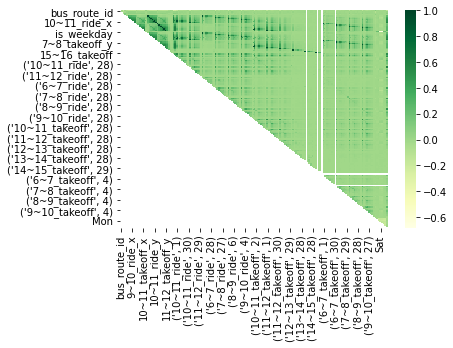

In [163]:
df_merged_X_train_corr_triu = df_merged_X_train_corr.where(np.triu(np.ones(df_merged_X_train_corr.shape),k=1).astype(np.bool))
sns.heatmap(df_merged_X_train_corr_triu,cmap=plt.cm.YlGn)

In [164]:
df_merged_X_train_corr_btw_values = df_merged_X_train_corr_triu.stack().reset_index()
df_merged_X_train_corr_btw_values.columns = np.append(df_merged_X_train_corr_btw_values.columns[:2],"correlation")
df_merged_X_train_corr_btw_values

,level_0,level_1,correlation
0,bus_route_id,station_code,-0.015897
1,bus_route_id,latitude,-0.196758
2,bus_route_id,longitude,0.010187
3,bus_route_id,6~7_ride_x,-0.070173
4,bus_route_id,7~8_ride_x,-0.119180
...,...,...,...
12875,Sun,Tue,-0.161448
12876,Sun,18~20_ride,-0.016739
12877,Thr,Tue,-0.172661
12878,Thr,18~20_ride,0.001259


In [0]:
list_drop_col = df_merged_X_train_corr_btw_values.loc[df_merged_X_train_corr_btw_values.sort_values(by="correlation",ascending=False)["correlation"] > 0.80]["level_1"].values

df_merged_X_train.drop(columns=list_drop_col,axis=1,inplace=True)
df_merged_X_test.drop(columns=list_drop_col,axis=1,inplace=True)

2020-03-18(수) input value와 target value 시간대 통일

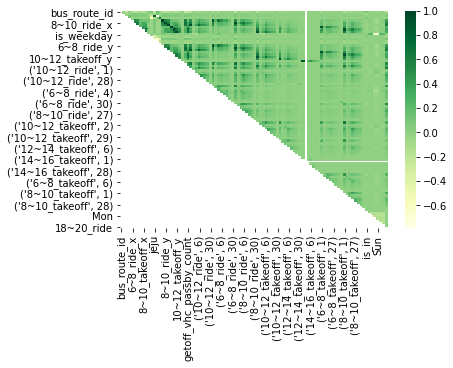

In [166]:
df_merged_X_train3 = pd.concat([df_merged_X_train3.loc[:,df_merged_X_train3.columns[1:]],target],axis=1)
df_merged_X_train3.head()

df_merged_X_train3_corr = df_merged_X_train3.corr()

df_merged_X_train3_corr_triu = df_merged_X_train3_corr.where(np.triu(np.ones(df_merged_X_train3_corr.shape),k=1).astype(np.bool))
sns.heatmap(df_merged_X_train3_corr_triu,cmap=plt.cm.YlGn)

In [167]:
df_merged_X_train3_corr_btw_values = df_merged_X_train3_corr_triu.stack().reset_index()
df_merged_X_train3_corr_btw_values.columns = np.append(df_merged_X_train3_corr_btw_values.columns[:2],"correlation")
df_merged_X_train3_corr_btw_values

,level_0,level_1,correlation
0,bus_route_id,station_code,-0.015897
1,bus_route_id,latitude,-0.196758
2,bus_route_id,longitude,0.010187
3,bus_route_id,6~8_ride_x,-0.121064
4,bus_route_id,8~10_ride_x,-0.152482
...,...,...,...
4460,Sun,Tue,-0.161448
4461,Sun,18~20_ride,-0.016739
4462,Thr,Tue,-0.172661
4463,Thr,18~20_ride,0.001259


In [168]:
df_merged_X_train3_corr_btw_values.loc[df_merged_X_train3_corr_btw_values.sort_values(by="correlation",ascending=False)["correlation"] > 0.80]

,level_0,level_1,correlation
196,latitude,jeju,0.853193
380,6~8_ride_x,6~8_ride_y,1.000000
398,6~8_ride_x,"(6~8_ride, 1)",0.901171
470,8~10_ride_x,8~10_ride_y,1.000000
495,8~10_ride_x,"(8~10_ride, 1)",0.942655
559,10~12_ride_x,10~12_ride_y,1.000000
567,10~12_ride_x,"(10~12_ride, 1)",0.922483
647,6~8_takeoff_x,6~8_takeoff_y,0.994034
700,6~8_takeoff_x,"(6~8_takeoff, 1)",0.906123
734,8~10_takeoff_x,8~10_takeoff_y,0.999997


In [169]:
df_merged_X_train3.head()

,bus_route_id,station_code,latitude,longitude,6~8_ride_x,8~10_ride_x,10~12_ride_x,6~8_takeoff_x,8~10_takeoff_x,10~12_takeoff_x,is_weekday,gosan,jeju,po,seongsan,6~8_ride_y,8~10_ride_y,10~12_ride_y,6~8_takeoff_y,8~10_takeoff_y,10~12_takeoff_y,12~14_takeoff,14~16_takeoff,geton_vhc_passby_count,getoff_vhc_passby_count,"(10~12_ride, 1)","(10~12_ride, 2)","(10~12_ride, 4)","(10~12_ride, 6)","(10~12_ride, 27)","(10~12_ride, 28)","(10~12_ride, 29)","(10~12_ride, 30)","(6~8_ride, 1)","(6~8_ride, 2)","(6~8_ride, 4)","(6~8_ride, 6)","(6~8_ride, 27)","(6~8_ride, 28)","(6~8_ride, 29)",...,"(10~12_takeoff, 30)","(12~14_takeoff, 1)","(12~14_takeoff, 2)","(12~14_takeoff, 4)","(12~14_takeoff, 6)","(12~14_takeoff, 27)","(12~14_takeoff, 28)","(12~14_takeoff, 29)","(12~14_takeoff, 30)","(14~16_takeoff, 1)","(14~16_takeoff, 2)","(14~16_takeoff, 4)","(14~16_takeoff, 6)","(14~16_takeoff, 27)","(14~16_takeoff, 28)","(14~16_takeoff, 29)","(6~8_takeoff, 1)","(6~8_takeoff, 2)","(6~8_takeoff, 4)","(6~8_takeoff, 6)","(6~8_takeoff, 27)","(6~8_takeoff, 28)","(6~8_takeoff, 29)","(6~8_takeoff, 30)","(8~10_takeoff, 1)","(8~10_takeoff, 2)","(8~10_takeoff, 4)","(8~10_takeoff, 6)","(8~10_takeoff, 27)","(8~10_takeoff, 28)","(8~10_takeoff, 29)","(8~10_takeoff, 30)",is_in,Fri,Mon,Sat,Sun,Thr,Tue,18~20_ride
0,4270000,344,33.48990,126.49373,1.0,7.0,8.0,0.0,0.0,0.0,False,0,1,0,0,1.0,7.0,8.0,0.0,0.0,0.0,0.0,0.0,7.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,4270000,357,33.48944,126.48508,5.0,6.0,11.0,0.0,0.0,0.0,False,0,1,0,0,5.0,6.0,11.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0,11.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,0.0,0.0,0.0,1.0,0.0,0.0,5.0
2,4270000,432,33.48181,126.47352,2.0,2.0,0.0,0.0,0.0,0.0,False,0,1,0,0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,0.0,0.0,0.0,1.0,0.0,0.0,2.0
3,4270000,1579,33.50577,126.49252,17.0,32.0,30.0,0.0,0.0,0.0,False,0,1,0,0,17.0,32.0,30.0,0.0,0.0,0.0,0.0,0.0,13.0,0.0,30.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True,0.0,0.0,0.0,1.0,0.0,0.0,53.0
4,4270000,1646,33.25579,126.41260,0.0,0.0,0.0,0.0,1.0,0.0,False,0,0,1,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [0]:
# 검증하려고 추가한 컬럼이 상관관계가 상당히 높아서 모두 제거 대상에 포함
list_estimated_col = [k for k in df_merged_X_train3.columns if '_y' in k]

# 타임라인별 탑승자 카테고리에 따른 탑승자수 중에서 일반 탑승자 수는 기존 탑승자 수와 높은 상관관계를 보임.
result_columns = []

columns = df_merged_X_train3.columns[25:88]

columns_boolean = np.array([element[1] for element in columns]) == 1

for idx,element in enumerate(columns_boolean):
  if element == 1:
      result_columns.append(columns[idx])

df_merged_X_train3.drop(list_estimated_col,inplace=True,axis=1)
df_merged_X_train3.drop(result_columns,inplace=True,axis=1)
df_merged_X_test3.drop(list_estimated_col,inplace=True,axis=1)
df_merged_X_test3.drop(result_columns,inplace=True,axis=1)

df_merged_X_train3.drop("jeju",inplace=True,axis=1)
df_merged_X_test3.drop("jeju",inplace=True,axis=1)

In [171]:
df_merged_X_train3.head()

,bus_route_id,station_code,latitude,longitude,6~8_ride_x,8~10_ride_x,10~12_ride_x,6~8_takeoff_x,8~10_takeoff_x,10~12_takeoff_x,is_weekday,gosan,po,seongsan,12~14_takeoff,14~16_takeoff,geton_vhc_passby_count,getoff_vhc_passby_count,"(10~12_ride, 2)","(10~12_ride, 4)","(10~12_ride, 6)","(10~12_ride, 27)","(10~12_ride, 28)","(10~12_ride, 29)","(10~12_ride, 30)","(6~8_ride, 2)","(6~8_ride, 4)","(6~8_ride, 6)","(6~8_ride, 27)","(6~8_ride, 28)","(6~8_ride, 29)","(6~8_ride, 30)","(8~10_ride, 2)","(8~10_ride, 4)","(8~10_ride, 6)","(8~10_ride, 27)","(8~10_ride, 28)","(8~10_ride, 29)","(8~10_ride, 30)","(10~12_takeoff, 2)",...,"(10~12_takeoff, 6)","(10~12_takeoff, 27)","(10~12_takeoff, 28)","(10~12_takeoff, 29)","(10~12_takeoff, 30)","(12~14_takeoff, 2)","(12~14_takeoff, 4)","(12~14_takeoff, 6)","(12~14_takeoff, 27)","(12~14_takeoff, 28)","(12~14_takeoff, 29)","(12~14_takeoff, 30)","(14~16_takeoff, 2)","(14~16_takeoff, 4)","(14~16_takeoff, 6)","(14~16_takeoff, 27)","(14~16_takeoff, 28)","(14~16_takeoff, 29)","(6~8_takeoff, 2)","(6~8_takeoff, 4)","(6~8_takeoff, 6)","(6~8_takeoff, 27)","(6~8_takeoff, 28)","(6~8_takeoff, 29)","(6~8_takeoff, 30)","(8~10_takeoff, 2)","(8~10_takeoff, 4)","(8~10_takeoff, 6)","(8~10_takeoff, 27)","(8~10_takeoff, 28)","(8~10_takeoff, 29)","(8~10_takeoff, 30)",is_in,Fri,Mon,Sat,Sun,Thr,Tue,18~20_ride
0,4270000,344,33.48990,126.49373,1.0,7.0,8.0,0.0,0.0,0.0,False,0,0,0,0.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,4270000,357,33.48944,126.48508,5.0,6.0,11.0,0.0,0.0,0.0,False,0,0,0,0.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,0.0,0.0,0.0,1.0,0.0,0.0,5.0
2,4270000,432,33.48181,126.47352,2.0,2.0,0.0,0.0,0.0,0.0,False,0,0,0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,0.0,0.0,0.0,1.0,0.0,0.0,2.0
3,4270000,1579,33.50577,126.49252,17.0,32.0,30.0,0.0,0.0,0.0,False,0,0,0,0.0,0.0,13.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True,0.0,0.0,0.0,1.0,0.0,0.0,53.0
4,4270000,1646,33.25579,126.41260,0.0,0.0,0.0,0.0,1.0,0.0,False,0,1,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [172]:
df_merged_X_train3_corr = df_merged_X_train3.corr()
df_merged_X_train3_corr_triu = df_merged_X_train3_corr.where(np.triu(np.ones(df_merged_X_train3_corr.shape),k=1).astype(np.bool))
df_merged_X_train3_corr_btw_values = df_merged_X_train3_corr_triu.stack().reset_index()
df_merged_X_train3_corr_btw_values.columns = np.append(df_merged_X_train3_corr_btw_values.columns[:2],"correlation")
df_merged_X_train3_corr_btw_values

,level_0,level_1,correlation
0,bus_route_id,station_code,-0.015897
1,bus_route_id,latitude,-0.196758
2,bus_route_id,longitude,0.010187
3,bus_route_id,6~8_ride_x,-0.121064
4,bus_route_id,8~10_ride_x,-0.152482
...,...,...,...
3155,Sun,Tue,-0.161448
3156,Sun,18~20_ride,-0.016739
3157,Thr,Tue,-0.172661
3158,Thr,18~20_ride,0.001259


## Data Modeling

이제 우리가 가진 데이터셋을 활용하여 학습모델을 만들고 결과를 추출해보자. 하지만 시간적 제약으로 인해 우리는 비교적 간단하지만 좋은 결과를 예측하는 Tree Model중 하나인 Random Forest 모델을 사용하자.

In [0]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

rf = RandomForestRegressor(random_state=101,n_estimators=100)

X_train = df_merged_X_train.drop(columns=["id","18~20_ride"],axis=1)
X_train_id = df_merged_X_train["id"]

X_train = X_train.values

X_test = df_merged_X_test.drop(columns="id",axis=1)
X_test_id = df_merged_X_test["id"]

X_test = X_test.values
y = df_merged_X_train["18~20_ride"]

score_dict = dict()
result_dict = dict()

KFold = KFold(n_splits=5,shuffle=True,random_state=12)

for i,(train_indexes,test_indexes) in enumerate(KFold.split(X_train,y)):
  print("#"*20+f"{i+1} fold processing...")
  X_fold = X_train[train_indexes]
  y_fold = y[train_indexes]
  X_test_fold = X_train[test_indexes]
  y_fold_result = y[test_indexes]

  print("#"*10+f"{i+1} fold Learning processing...")
  %time rf.fit(X_fold,y_fold)

  print("#"*10+f"{i+1} fold Predict processing...")
  vaildation_result = rf.predict(X_test_fold)

  score = mean_squared_error(y_fold_result,vaildation_result)**0.5

  print(f"The RMSE Score of Random Forest is {score} at {i+1} fold ")

  score_dict[i] = score

  result = rf.predict(X_test)
  result_dict[i] = result

print(f"The Mean RMSE Score of Random Forest is {np.mean(list(score_dict.values()))} at 5 folds ")

####################1 fold processing...
##########1 fold Learning processing...
CPU times: user 15min 43s, sys: 97.6 ms, total: 15min 43s
Wall time: 15min 43s
##########1 fold Predict processing...
The RMSE Score of Random Forest is 2.9055477079695686 at 1 fold 
####################2 fold processing...
##########2 fold Learning processing...
CPU times: user 11min 48s, sys: 76.2 ms, total: 11min 48s
Wall time: 11min 48s
##########2 fold Predict processing...
The RMSE Score of Random Forest is 2.876435087056438 at 2 fold 
####################3 fold processing...
##########3 fold Learning processing...
CPU times: user 12min 24s, sys: 80.6 ms, total: 12min 24s
Wall time: 12min 24s
##########3 fold Predict processing...
The RMSE Score of Random Forest is 2.9131403286372692 at 3 fold 
####################4 fold processing...
##########4 fold Learning processing...
CPU times: user 11min 44s, sys: 45.7 ms, total: 11min 44s
Wall time: 11min 44s
##########4 fold Predict processing...
The RMSE S

In [0]:
df_result = pd.DataFrame(result_dict)
df_result = df_result.mean(axis=1).to_frame()
df_result.columns = ["18~20_ride"]
df_test_id = X_test_id.to_frame()
df_submission = pd.concat([df_test_id,df_result],axis=1)

## Submission

In [0]:
df_submission.to_csv(path+"submission_데이콘 서포터즈 1기_권영인.csv",index=False)